 -*- coding: utf-8 -*-

Created on Tue Jan 25 11:24:17 2022

Last update on Sun Sep 04 08:49:12 2022

@author: Giovanni Scabbia - QEERI

@team: QEERI, Energy Conversion Program

Description: Script to process and analize the raw PVA data:

    1. Analysis of the albedo
    2. Analysis of the PV data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import datetime
import seaborn as sns

In [2]:
# load the data
alb_tilt = pd.read_csv('./data/tilted_albedo.csv')
alb_vert = pd.read_csv('./data/vertical_albedo.csv')
data = pd.read_csv('./data/raw_data_04.9.2022.csv')

# set the timestamp as datatime
alb_tilt['timestamp'] = pd.to_datetime(alb_tilt['timestamp'])
alb_vert['timestamp'] = pd.to_datetime(alb_vert['timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'])

alb_others = data[['timestamp','ALB_1', 'G_POA_4', 'GHI_1']].copy(deep=True).dropna()

raw_alb_others = alb_others.copy(deep=True)

#### Analysis of the albedo

(array([18140., 18262., 18383., 18506., 18628., 18748., 18871., 18993.,
        19113., 19236.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

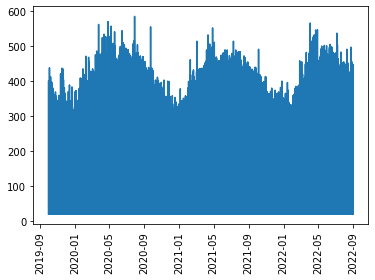

In [3]:
#### cleanining ALB_1 data

# remove observations < 20 or > 600 W/m2
alb_others.loc[(alb_others['ALB_1'] < 20)|(alb_others['ALB_1'] > 600), 'ALB_1'] = np.nan

# remove values > 20 before 5 am and after 7 pm
alb_others.loc[((alb_others['timestamp'].dt.hour < 5)|(alb_others['timestamp'].dt.hour > 19))&(alb_others['ALB_1']>20), 
               'ALB_1'] = np.nan

# remove a portion of the data that shows inconsistent values (between 23 - 27 Sep 2020)
alb_others.loc[(alb_others['timestamp'] > pd.to_datetime('23/09/2020 08:00'))&
               (alb_others['timestamp'] < pd.to_datetime('27/09/2020 09:00')), 'ALB_1'] = np.nan


# plot the data for visualization
%matplotlib inline
plt.plot(alb_others['timestamp'],alb_others['ALB_1'])
plt.xticks(rotation='vertical')


(array([18140., 18262., 18383., 18506., 18628., 18748., 18871., 18993.,
        19113., 19236.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

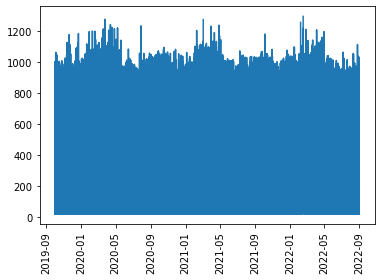

In [90]:
#### cleaning the G_POA_4 data

# remove observations < 20
alb_others.loc[alb_others['G_POA_4'] < 20, 'G_POA_4'] = np.nan

# remove observations > 1300
alb_others.loc[alb_others['G_POA_4'] > 1300, 'G_POA_4'] = np.nan

# remove values > 20 before 5 am and after 7 pm
alb_others.loc[((alb_others['timestamp'].dt.hour < 5)|(alb_others['timestamp'].dt.hour > 19))&(alb_others['G_POA_4']>30), 
               'G_POA_4'] = np.nan

# plot the data for visualization
%matplotlib inline
plt.plot(alb_others['timestamp'],np.abs(alb_others['G_POA_4']))
plt.xticks(rotation='vertical')


(array([18140., 18262., 18383., 18506., 18628., 18748., 18871., 18993.,
        19113., 19236.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

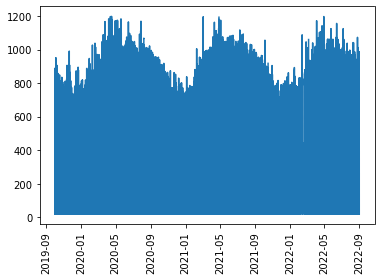

In [5]:
#### cleaning GHI_1 data

# remove observations < 20 or > 1200
alb_others.loc[(alb_others['GHI_1'] < 20)|(alb_others['GHI_1'] > 1200), 'GHI_1'] = np.nan

# remove values > 20 before 5 am and after 7 pm
alb_others.loc[((alb_others['timestamp'].dt.hour < 5)|(alb_others['timestamp'].dt.hour > 19))&(alb_others['GHI_1']>20), 
               'GHI_1'] = np.nan

# plot the data for visualization
%matplotlib inline
plt.plot(alb_others['timestamp'],alb_others['GHI_1'])
plt.xticks(rotation='vertical')


In [6]:
# calculate albedo = ALB_1 / GHI_1

alb_others['albedo'] = alb_others['ALB_1'] / alb_others['GHI_1']

# add aggregate time suport variables
alb_others['dt_hr'] = alb_others['timestamp'].dt.floor('H')
alb_others['date'] = alb_others['timestamp'].dt.date
alb_others['year'] = alb_others['timestamp'].dt.year

# filter out values < 0 or > 1
alb_others.loc[(alb_others['albedo'] < 0)|(alb_others['albedo'] > 1), 'albedo'] = np.nan

# calculate hourly aggregate
albedo_hr = alb_others[['dt_hr','year','date','albedo']].groupby(by='dt_hr', as_index=False ).agg({
    'dt_hr':'first',
    'year':'first',
    'albedo':'mean', 
    'date': 'first'})

# calculate daily aggregate
albedo_day = alb_others[['date','albedo']].groupby(by='date', as_index=False ).mean()

In [7]:
# cleaning tilted radiation data

# remove observations > 300 W/m2
alb_tilt.loc[alb_tilt['TA_low'] > 300, 'TA_low'] = np.nan
alb_tilt.loc[alb_tilt['TA_mid'] > 300, 'TA_mid'] = np.nan
alb_tilt.loc[alb_tilt['TA_High'] > 300, 'TA_High'] = np.nan

# remove night values before 5 am and after 7 pm
alb_tilt.loc[(alb_tilt['timestamp'].dt.hour < 5)|(alb_tilt['timestamp'].dt.hour > 19), 
               ['TA_low','TA_mid','TA_High']] = np.nan

In [8]:
# cleaning vertical radiation data

# remove observations < 20 and > 1200 W/m2
alb_vert.loc[(alb_vert['V_E'] < 20)|(alb_vert['V_E'] > 1200), 'V_E'] = np.nan
alb_vert.loc[(alb_vert['V_W'] < 20)|(alb_vert['V_W'] > 1200), 'V_W'] = np.nan

# remove night values before 5 am and after 7 pm
alb_vert.loc[(alb_vert['timestamp'].dt.hour < 5)|(alb_vert['timestamp'].dt.hour > 19), 
               ['V_E','V_W']] = np.nan
               

In [9]:
## save all albedo data

alb_data = alb_others[['timestamp', 'ALB_1', 'G_POA_4', 'GHI_1', 'albedo']].copy(deep=True)
alb_data = alb_data.merge(alb_tilt, on='timestamp', how='outer').sort_values(by='timestamp').reset_index(drop=True)
alb_data = alb_data.merge(alb_vert, on='timestamp', how='outer').sort_values(by='timestamp').reset_index(drop=True)

last_date = str(alb_data['timestamp'].max().date())

alb_data[['timestamp', 'ALB_1', 'G_POA_4', 'GHI_1', 'TA_low',
       'TA_mid', 'TA_High', 'V_E', 'V_W','albedo']].to_csv('./data/solarRad_albedo_data_'+last_date+'.csv')

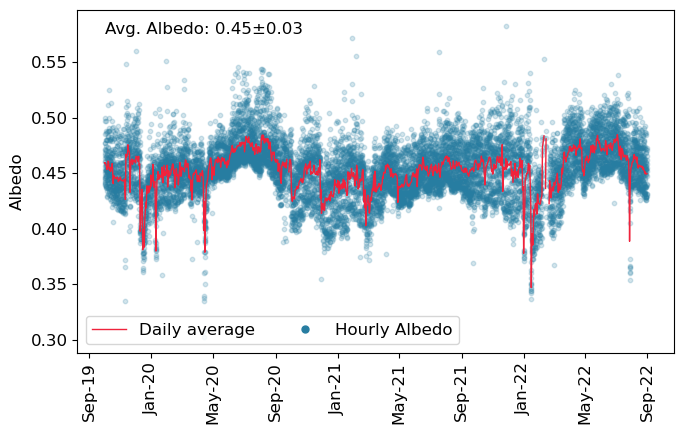

In [10]:
# plot the hourly albedo with daily average

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 12})

albedo_day_mk = mlines.Line2D([], [], color='#ef233c', linestyle='-', linewidth=1, label='Daily average')
albedo_mk = mlines.Line2D([], [], color='#277da1', marker='.', linestyle='', markersize=10, label='Hourly Albedo')


xformatter = mdates.DateFormatter('%b-%y')

fig, ax = plt.subplots(figsize=(7,4.5))
ax.scatter(albedo_hr['date'], albedo_hr['albedo'], color='#277da1', alpha=0.2, s=10)
ax.plot(albedo_day['date'], albedo_day['albedo'], color='#ef233c', linewidth=1)

ax.legend(handles=[albedo_day_mk, albedo_mk], loc=3,ncol=2)
ax.set_ylabel('Albedo')

ax.text(albedo_hr['date'][0], 0.575, 'Avg. Albedo: '+
        str(round(np.mean(albedo_hr['albedo']),2))+'±'+str(round(np.std(albedo_hr['albedo']),2)), fontsize=12)

ax.xaxis.set_major_formatter(xformatter)

plt.xticks(rotation='vertical')
fig.tight_layout()

fig.savefig('./Figures/1.albedo.tif')
fig.savefig('./Figures/1.albedo.svg')

plt.rcdefaults()

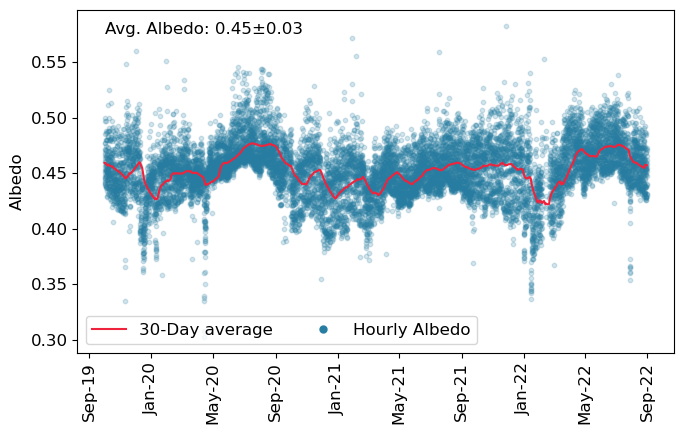

In [11]:
# plot the hourly albedo with monthly (30-days) average

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 12})

albedo_day_mk = mlines.Line2D([], [], color='#ef233c', linestyle='-', linewidth=1.5, label='30-Day average')
albedo_mk = mlines.Line2D([], [], color='#277da1', marker='.', linestyle='', markersize=10, label='Hourly Albedo')


xformatter = mdates.DateFormatter('%b-%y')

fig, ax = plt.subplots(figsize=(7,4.5))
ax.scatter(albedo_hr['date'], albedo_hr['albedo'], color='#277da1', alpha=0.2, s=10)
ax.plot(albedo_day['date'], albedo_day['albedo'].rolling(window=30, min_periods=1).mean(), color='#ef233c', linewidth=1.5)

ax.legend(handles=[albedo_day_mk, albedo_mk], loc=3,ncol=2)
ax.set_ylabel('Albedo')

ax.text(albedo_hr['date'][0], 0.575, 'Avg. Albedo: '+
        str(round(np.mean(albedo_hr['albedo']),2))+'±'+str(round(np.std(albedo_hr['albedo']),2)), fontsize=12)

ax.xaxis.set_major_formatter(xformatter)

plt.xticks(rotation='vertical')
fig.tight_layout()

fig.savefig('./Figures/1.albedo_30d.tif')
fig.savefig('./Figures/1.albedo_30d.svg')

plt.rcdefaults()

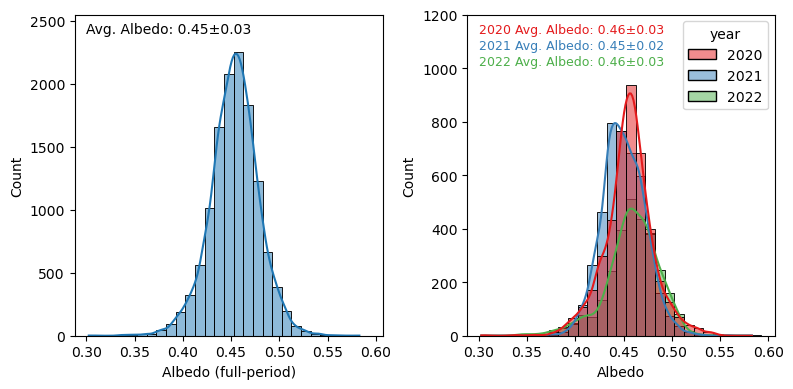

In [12]:
# plot the statistical distribution of the albedo for each year (count)

import seaborn as sns
%matplotlib inline
plt.rcdefaults()

fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.histplot(data=albedo_hr, stat='count', ax=ax[0], x='albedo', binwidth=0.01, kde=True)
ax[0].set_xlabel('Albedo (full-period)')
sns.histplot(data=albedo_hr.loc[(albedo_hr['year']==2020)|(albedo_hr['year']==2021)|(albedo_hr['year']==2022)], stat='count', ax=ax[1],
             x='albedo', binwidth=0.01, kde=True, hue="year", palette='Set1')
ax[1].set_xlabel('Albedo')

ax[0].text(0.3, 2400, 'Avg. Albedo: '+
        str(round(np.mean(albedo_hr['albedo']),2))+'±'+str(round(np.std(albedo_hr['albedo']),2)), fontsize=10)

x = albedo_hr.loc[(albedo_hr['year']==2020), 'albedo']
ax[1].text(0.3, 1130, '2020 Avg. Albedo: '+
        str(round(np.mean(x),2))+'±'+str(round(np.std(x),2)), fontsize=9, color='#e41a1c')
x = albedo_hr.loc[(albedo_hr['year']==2021), 'albedo']
ax[1].text(0.3, 1070, '2021 Avg. Albedo: '+
        str(round(np.mean(x),2))+'±'+str(round(np.std(x),2)), fontsize=9, color='#377eb8')
x = albedo_hr.loc[(albedo_hr['year']==2022), 'albedo']
ax[1].text(0.3, 1010, '2022 Avg. Albedo: '+
        str(round(np.mean(x),2))+'±'+str(round(np.std(x),2)), fontsize=9, color='#4daf4a')

ax[0].set_ylim([0, 2550])
ax[1].set_ylim([0, 1200])

fig.tight_layout()

fig.savefig('./Figures/2.albedo_dens_count.tif')
fig.savefig('./Figures/2.albedo_dens_count.svg')

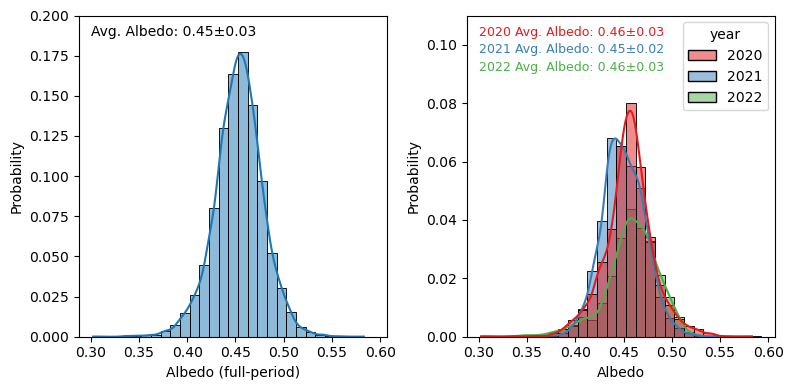

In [13]:
# plot the statistical distribution of the albedo for each year (probability)

import seaborn as sns
%matplotlib inline
plt.rcdefaults()

fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.histplot(data=albedo_hr, stat='probability', ax=ax[0], x='albedo', binwidth=0.01, kde=True)
ax[0].set_xlabel('Albedo (full-period)')
sns.histplot(data=albedo_hr.loc[(albedo_hr['year']==2020)|(albedo_hr['year']==2021)|(albedo_hr['year']==2022)], 
             stat='probability', ax=ax[1],
             x='albedo', binwidth=0.01, kde=True, hue="year", palette='Set1')
ax[1].set_xlabel('Albedo')


ax[0].text(0.3, 0.1875, 'Avg. Albedo: '+
        str(round(np.mean(albedo_hr['albedo']),2))+'±'+str(round(np.std(albedo_hr['albedo']),2)), fontsize=10)


x = albedo_hr.loc[(albedo_hr['year']==2020), 'albedo']
ax[1].text(0.3, 0.103, '2020 Avg. Albedo: '+
        str(round(np.mean(x),2))+'±'+str(round(np.std(x),2)), fontsize=9, color='#e41a1c')
x = albedo_hr.loc[(albedo_hr['year']==2021), 'albedo']
ax[1].text(0.3, 0.097, '2021 Avg. Albedo: '+
        str(round(np.mean(x),2))+'±'+str(round(np.std(x),2)), fontsize=9, color='#377eb8')
x = albedo_hr.loc[(albedo_hr['year']==2022), 'albedo']
ax[1].text(0.3, 0.091, '2022 Avg. Albedo: '+
        str(round(np.mean(x),2))+'±'+str(round(np.std(x),2)), fontsize=9, color='#4daf4a')

ax[0].set_ylim([0, 0.2])
ax[1].set_ylim([0, 0.11])


fig.tight_layout()

fig.savefig('./Figures/2.albedo_dens_prob.tif')
fig.savefig('./Figures/2.albedo_dens_prob.svg')

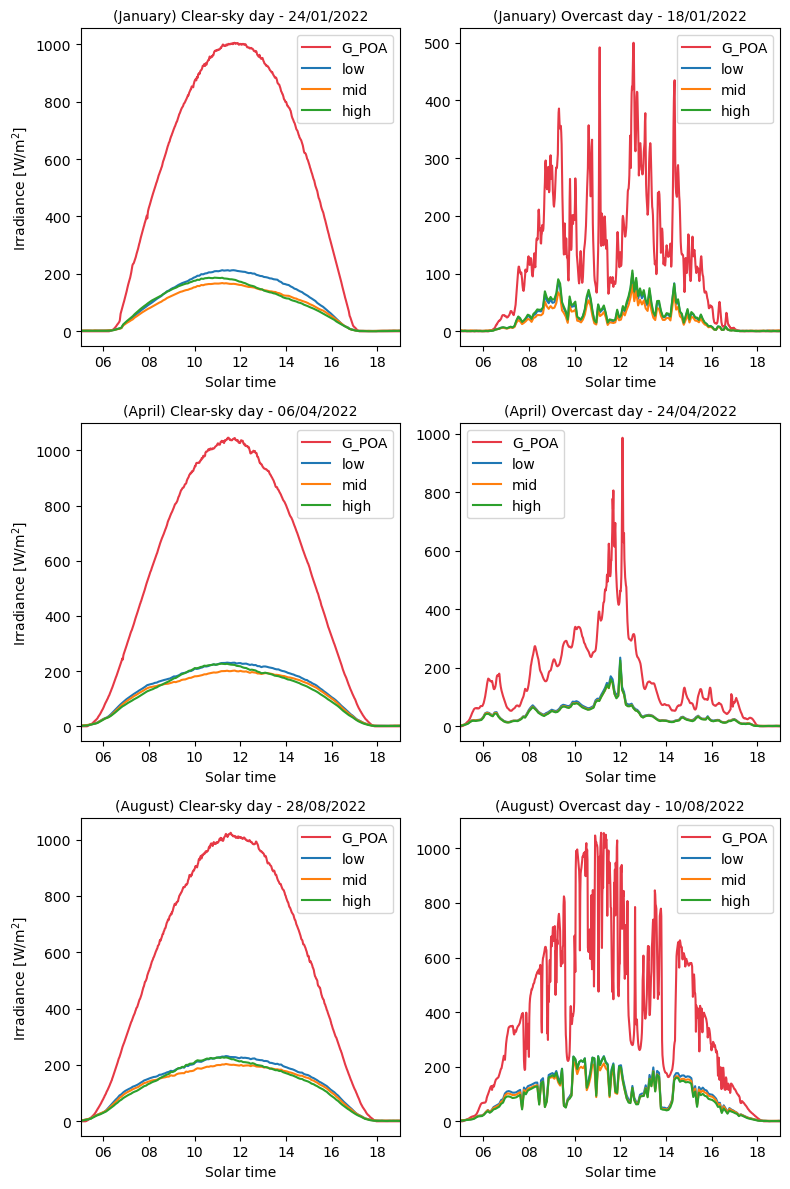

In [14]:
# Plot the comparison G_POA vs back irradiation (low, mid, high) in January, April, and September

# colors
col_POA = '#e63946'
col_low = '#1f77b4'
col_mid = '#ff7f0e'
col_hig = '#2ca02c'

%matplotlib inline
plt.rcdefaults()

xformatter = mdates.DateFormatter('%H')

plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(3,2, figsize=(8,12))

### January

sunny = alb_tilt.loc[alb_tilt['timestamp'].dt.date == datetime.date(2022,1,24), ['timestamp', 'TA_low', 'TA_mid', 'TA_High']]
overcast = alb_tilt.loc[alb_tilt['timestamp'].dt.date == datetime.date(2022,1,18), ['timestamp', 'TA_low', 'TA_mid', 'TA_High']]

ax[0][0].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,1,24), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,1,24), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[0][0].plot(sunny['timestamp'], sunny['TA_low'], label='low', color=col_low)
ax[0][0].plot(sunny['timestamp'], sunny['TA_mid'], label='mid', color=col_mid)
ax[0][0].plot(sunny['timestamp'], sunny['TA_High'], label='high', color=col_hig)
ax[0][0].legend()
ax[0][0].set_title('(January) Clear-sky day - 24/01/2022', fontsize=10)
ax[0][0].set_ylabel('Irradiance [W/m$^2$]')
ax[0][0].set_xlabel('Solar time')

ax[0][0].set_xlim([pd.to_datetime('2022-01-24 05:00:00'), pd.to_datetime('2022-01-24 19:00:00')])

ax[0][0].xaxis.set_major_formatter(xformatter)


ax[0][1].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,1,18), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,1,18), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[0][1].plot(overcast['timestamp'], overcast['TA_low'], label='low', color=col_low)
ax[0][1].plot(overcast['timestamp'], overcast['TA_mid'], label='mid', color=col_mid)
ax[0][1].plot(overcast['timestamp'], overcast['TA_High'], label='high', color=col_hig)
ax[0][1].legend()
ax[0][1].set_title('(January) Overcast day - 18/01/2022', fontsize=10)
ax[0][1].set_ylabel('') #Irradiance [W/m$^2$]
ax[0][1].set_xlabel('Solar time')

ax[0][1].set_xlim([pd.to_datetime('2022-01-18 05:00:00'), pd.to_datetime('2022-01-18 19:00:00')])

ax[0][1].xaxis.set_major_formatter(xformatter)

### April

sunny = alb_tilt.loc[alb_tilt['timestamp'].dt.date == datetime.date(2022,4,6), ['timestamp', 'TA_low', 'TA_mid', 'TA_High']]
overcast = alb_tilt.loc[alb_tilt['timestamp'].dt.date == datetime.date(2022,4,26), ['timestamp', 'TA_low', 'TA_mid', 'TA_High']]

ax[1][0].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,4,6), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,4,6), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[1][0].plot(sunny['timestamp'], sunny['TA_low'], label='low', color=col_low)
ax[1][0].plot(sunny['timestamp'], sunny['TA_mid'], label='mid', color=col_mid)
ax[1][0].plot(sunny['timestamp'], sunny['TA_High'], label='high', color=col_hig)
ax[1][0].legend()
ax[1][0].set_title('(April) Clear-sky day - 06/04/2022', fontsize=10)
ax[1][0].set_ylabel('Irradiance [W/m$^2$]')
ax[1][0].set_xlabel('Solar time')

ax[1][0].set_xlim([pd.to_datetime('2022-04-06 05:00:00'), pd.to_datetime('2022-04-06 19:00:00')])

ax[1][0].xaxis.set_major_formatter(xformatter)


ax[1][1].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,4,26), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,4,26), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[1][1].plot(overcast['timestamp'], overcast['TA_low'], label='low', color=col_low)
ax[1][1].plot(overcast['timestamp'], overcast['TA_mid'], label='mid', color=col_mid)
ax[1][1].plot(overcast['timestamp'], overcast['TA_High'], label='high', color=col_hig)
ax[1][1].legend(loc=2)
ax[1][1].set_title('(April) Overcast day - 24/04/2022', fontsize=10)
ax[1][1].set_ylabel('') #Irradiance [W/m$^2$]
ax[1][1].set_xlabel('Solar time')

ax[1][1].set_xlim([pd.to_datetime('2022-04-26 05:00:00'), pd.to_datetime('2022-04-26 19:00:00')])

ax[1][1].xaxis.set_major_formatter(xformatter)

### August

sunny = alb_tilt.loc[alb_tilt['timestamp'].dt.date == datetime.date(2022,8,28), ['timestamp', 'TA_low', 'TA_mid', 'TA_High']]
overcast = alb_tilt.loc[alb_tilt['timestamp'].dt.date == datetime.date(2022,8,10), ['timestamp', 'TA_low', 'TA_mid', 'TA_High']]

ax[2][0].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,8,28), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,8,28), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[2][0].plot(sunny['timestamp'], sunny['TA_low'], label='low', color=col_low)
ax[2][0].plot(sunny['timestamp'], sunny['TA_mid'], label='mid', color=col_mid)
ax[2][0].plot(sunny['timestamp'], sunny['TA_High'], label='high', color=col_hig)
ax[2][0].legend()
ax[2][0].set_title('(August) Clear-sky day - 28/08/2022', fontsize=10)
ax[2][0].set_ylabel('Irradiance [W/m$^2$]')
ax[2][0].set_xlabel('Solar time')

ax[2][0].set_xlim([pd.to_datetime('2022-08-28 05:00:00'), pd.to_datetime('2022-08-28 19:00:00')])

ax[2][0].xaxis.set_major_formatter(xformatter)


ax[2][1].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,8,10), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,8,10), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[2][1].plot(overcast['timestamp'], overcast['TA_low'], label='low', color=col_low)
ax[2][1].plot(overcast['timestamp'], overcast['TA_mid'], label='mid', color=col_mid)
ax[2][1].plot(overcast['timestamp'], overcast['TA_High'], label='high', color=col_hig)
ax[2][1].legend()
ax[2][1].set_title('(August) Overcast day - 10/08/2022', fontsize=10)
ax[2][1].set_ylabel('') #Irradiance [W/m$^2$]
ax[2][1].set_xlabel('Solar time')

ax[2][1].set_xlim([pd.to_datetime('2022-08-10 05:00:00'), pd.to_datetime('2022-08-10 19:00:00')])

ax[2][1].xaxis.set_major_formatter(xformatter)

fig.tight_layout()

fig.savefig('./Figures/3.clear_cloud_tilt.tif')
fig.savefig('./Figures/3.clear_cloud_tilt.svg')


In [15]:
# calculate hourly mean for 'TA_low', 'TA_mid', 'TA_High'

alb_tilt['ts_dH'] = alb_tilt['timestamp'].dt.floor('H')

alb_tilt_hr = alb_tilt[['ts_dH', 'TA_low', 'TA_mid', 'TA_High']].groupby(by='ts_dH', as_index=False).mean()



In [16]:
# save the resulting data for the tilted back albedo
alb_tilt.to_csv('./data/alb_tilt.csv', index=False)
alb_tilt_hr.to_csv('./data/alb_tilt_hr.csv', index=False)

In [17]:
# calculate min and max values
alb_tilt_hr['min_val'] = alb_tilt_hr[['TA_low', 'TA_mid', 'TA_High']].min(axis=1)
alb_tilt_hr['max_val'] = alb_tilt_hr[['TA_low', 'TA_mid', 'TA_High']].max(axis=1)

# calculate non-uniformity
alb_tilt_hr['non_unif'] = 100*(alb_tilt_hr['max_val'] - alb_tilt_hr['min_val'])/(alb_tilt_hr['max_val']+alb_tilt_hr['min_val'])

# add date
alb_tilt_hr['date'] = alb_tilt_hr['ts_dH'].dt.date

# calculate daily median
alb_tilt_day = alb_tilt_hr[['date', 'non_unif']].groupby(by='date', as_index=False).median()

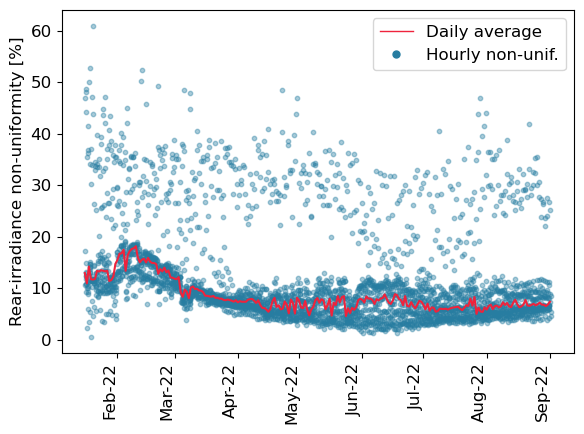

In [18]:
# plot the non-uniformity for rear irradiance of tilted modules

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 12})

albedo_day_mk = mlines.Line2D([], [], color='#ef233c', linestyle='-', linewidth=1, label='Daily average')
albedo_mk = mlines.Line2D([], [], color='#277da1', marker='.', linestyle='', markersize=10, label='Hourly non-unif.')


xformatter = mdates.DateFormatter('%b-%y')

fig, ax = plt.subplots(figsize=(6,4.5))
plt.scatter(alb_tilt_hr['ts_dH'], alb_tilt_hr['non_unif'], s=10, alpha=0.4, color='#277da1')
plt.plot(alb_tilt_day['date'], alb_tilt_day['non_unif'], color='#ef233c')

ax.legend(handles=[albedo_day_mk, albedo_mk], loc=1,ncol=1)
ax.set_ylabel('Rear-irradiance non-uniformity [%]')

ax.xaxis.set_major_formatter(xformatter)
fig.autofmt_xdate(rotation=45)
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig('./Figures/4.non-unif.tif')
fig.savefig('./Figures/4.non-unif.svg')

plt.rcdefaults()

In [19]:
# print mean non-uniformity
np.mean(alb_tilt_day['non_unif'])

8.579321456553126

In [20]:
# calculate the same for the hourly data

alb_data['ts_dH'] = alb_data['timestamp'].dt.floor('H')

alb_data_hr = alb_data[['ts_dH', 'ALB_1', 'G_POA_4', 'GHI_1', 'albedo', 'TA_low',
       'TA_mid', 'TA_High', 'V_E', 'V_W']].groupby(by='ts_dH', as_index=False).mean()

alb_data_hr['min_val'] = alb_data_hr[['TA_low', 'TA_mid', 'TA_High']].min(axis=1)
alb_data_hr['max_val'] = alb_data_hr[['TA_low', 'TA_mid', 'TA_High']].max(axis=1)

alb_data_hr['non_unif'] = 100*(alb_data_hr['max_val'] - alb_data_hr['min_val'])/(alb_data_hr['max_val']+alb_data_hr['min_val'])

## save the hourly average data

alb_data_hr = alb_data_hr.rename(columns={'ts_dH':'timestamp'})

alb_data_hr.to_csv('./data/hrAVG_solarRad_albedo_data_'+last_date+'.csv')

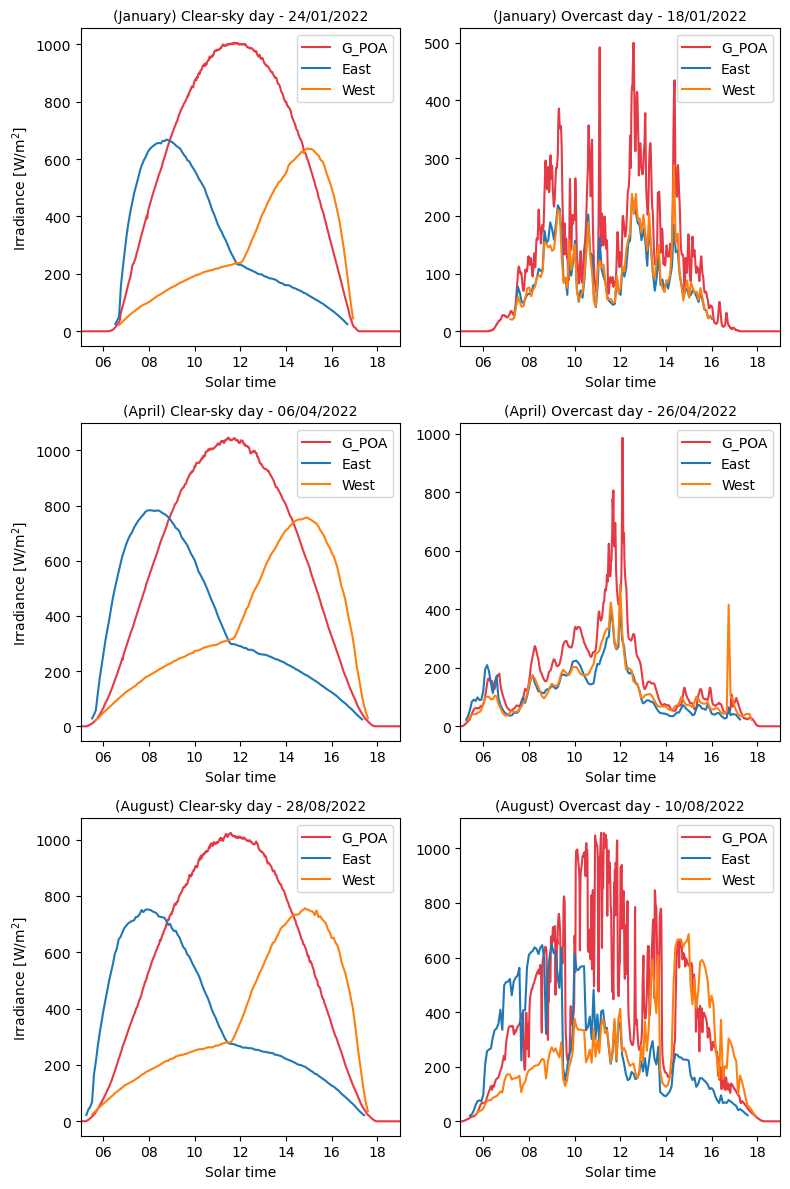

In [21]:
# Comparison G_POA vs Vertical W and E

xformatter = mdates.DateFormatter('%H')

# colors
col_POA = '#e63946'
col_E = '#1f77b4'
col_W = '#ff7f0e'

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(3,2, figsize=(8,12))

## January 

sunny = alb_vert.loc[alb_vert['timestamp'].dt.date == datetime.date(2022,1,24), ['timestamp', 'V_E', 'V_W']]
overcast = alb_vert.loc[alb_vert['timestamp'].dt.date == datetime.date(2022,1,18), ['timestamp', 'V_E', 'V_W']]

ax[0][0].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,1,24), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,1,24), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[0][0].plot(sunny['timestamp'], sunny['V_E'], label='East', color=col_E)
ax[0][0].plot(sunny['timestamp'], sunny['V_W'], label='West', color=col_W)
ax[0][0].legend()
ax[0][0].set_title('(January) Clear-sky day - 24/01/2022', fontsize=10)
ax[0][0].set_ylabel('Irradiance [W/m$^2$]')
ax[0][0].set_xlabel('Solar time')

ax[0][0].set_xlim([pd.to_datetime('2022-01-24 05:00:00'), pd.to_datetime('2022-01-24 19:00:00')])

ax[0][0].xaxis.set_major_formatter(xformatter)


ax[0][1].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,1,18), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,1,18), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[0][1].plot(overcast['timestamp'], overcast['V_E'], label='East', color=col_E)
ax[0][1].plot(overcast['timestamp'], overcast['V_W'], label='West', color=col_W)
ax[0][1].legend()
ax[0][1].set_title('(January) Overcast day - 18/01/2022', fontsize=10)
ax[0][1].set_ylabel('') #Irradiance [W/m$^2$]
ax[0][1].set_xlabel('Solar time')

ax[0][1].set_xlim([pd.to_datetime('2022-01-18 05:00:00'), pd.to_datetime('2022-01-18 19:00:00')])

ax[0][1].xaxis.set_major_formatter(xformatter)



## April 

sunny = alb_vert.loc[alb_vert['timestamp'].dt.date == datetime.date(2022,4,6), ['timestamp', 'V_E', 'V_W']]
overcast = alb_vert.loc[alb_vert['timestamp'].dt.date == datetime.date(2022,4,26), ['timestamp', 'V_E', 'V_W']]

ax[1][0].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,4,6), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,4,6), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[1][0].plot(sunny['timestamp'], sunny['V_E'], label='East', color=col_E)
ax[1][0].plot(sunny['timestamp'], sunny['V_W'], label='West', color=col_W)
ax[1][0].legend()
ax[1][0].set_title('(April) Clear-sky day - 06/04/2022', fontsize=10)
ax[1][0].set_ylabel('Irradiance [W/m$^2$]')
ax[1][0].set_xlabel('Solar time')

ax[1][0].set_xlim([pd.to_datetime('2022-04-06 05:00:00'), pd.to_datetime('2022-04-06 19:00:00')])

ax[1][0].xaxis.set_major_formatter(xformatter)


ax[1][1].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,4,26), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,4,26), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[1][1].plot(overcast['timestamp'], overcast['V_E'], label='East', color=col_E)
ax[1][1].plot(overcast['timestamp'], overcast['V_W'], label='West', color=col_W)
ax[1][1].legend()
ax[1][1].set_title('(April) Overcast day - 26/04/2022', fontsize=10)
ax[1][1].set_ylabel('') #Irradiance [W/m$^2$]
ax[1][1].set_xlabel('Solar time')

ax[1][1].set_xlim([pd.to_datetime('2022-04-26 05:00:00'), pd.to_datetime('2022-04-26 19:00:00')])

ax[1][1].xaxis.set_major_formatter(xformatter)




## August 

sunny = alb_vert.loc[alb_vert['timestamp'].dt.date == datetime.date(2022,8,28), ['timestamp', 'V_E', 'V_W']]
overcast = alb_vert.loc[alb_vert['timestamp'].dt.date == datetime.date(2022,8,10), ['timestamp', 'V_E', 'V_W']]

ax[2][0].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,8,28), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,8,28), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[2][0].plot(sunny['timestamp'], sunny['V_E'], label='East', color=col_E)
ax[2][0].plot(sunny['timestamp'], sunny['V_W'], label='West', color=col_W)
ax[2][0].legend()
ax[2][0].set_title('(August) Clear-sky day - 28/08/2022', fontsize=10)
ax[2][0].set_ylabel('Irradiance [W/m$^2$]')
ax[2][0].set_xlabel('Solar time')

ax[2][0].set_xlim([pd.to_datetime('2022-08-28 05:00:00'), pd.to_datetime('2022-08-28 19:00:00')])

ax[2][0].xaxis.set_major_formatter(xformatter)


ax[2][1].plot(raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,8,10), 'timestamp'],
         raw_alb_others.loc[raw_alb_others['timestamp'].dt.date == datetime.date(2022,8,10), 'G_POA_4'], 
           label='G_POA', color=col_POA)

ax[2][1].plot(overcast['timestamp'], overcast['V_E'], label='East', color=col_E)
ax[2][1].plot(overcast['timestamp'], overcast['V_W'], label='West', color=col_W)
ax[2][1].legend()
ax[2][1].set_title('(August) Overcast day - 10/08/2022', fontsize=10)
ax[2][1].set_ylabel('') #Irradiance [W/m$^2$]
ax[2][1].set_xlabel('Solar time')

ax[2][1].set_xlim([pd.to_datetime('2022-08-10 05:00:00'), pd.to_datetime('2022-08-10 19:00:00')])

ax[2][1].xaxis.set_major_formatter(xformatter)

fig.tight_layout()

fig.savefig('./Figures/4.clear_cloud_vert.tif')
fig.savefig('./Figures/4.clear_cloud_vert.svg')



#### Analysis of the PV data

In [22]:
# load the data
data = pd.read_csv('./data/raw_data_04.9.2022.csv')

# set timestamp to datetime data type
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [23]:
## filter out night observations of G_POA_4 

data.loc[((data['timestamp'].dt.hour < 5)|(data['timestamp'].dt.hour > 19)), 
               'G_POA_4'] = np.nan

###### - Temperature data

In [24]:
temp_data = data[['timestamp','tm_mono_clean_all','tm_mono_soil_all','tm_bf_tilt_clean_all','tm_bf_EW_clean_all']].copy(deep=True)

temp_data.loc[temp_data['tm_mono_clean_all']<=0, 'tm_mono_clean_all'] = np.nan
temp_data.loc[temp_data['tm_mono_soil_all']<=0, 'tm_mono_soil_all'] = np.nan
temp_data.loc[temp_data['tm_bf_tilt_clean_all']<=0, 'tm_bf_tilt_clean_all'] = np.nan
temp_data.loc[temp_data['tm_bf_EW_clean_all']<=0, 'tm_bf_EW_clean_all'] = np.nan

# create hourly median

temp_data['ts_dH'] = temp_data['timestamp'].dt.floor('H')
temp_data['date'] = temp_data['timestamp'].dt.date

temp_data_hr = temp_data.groupby(by='ts_dH', as_index=False).median()
temp_data_day = temp_data.groupby(by='date', as_index=False).median()


In [25]:
# save temperature data
temp_data.to_csv('./data/temperature_data_'+last_date+'.csv')

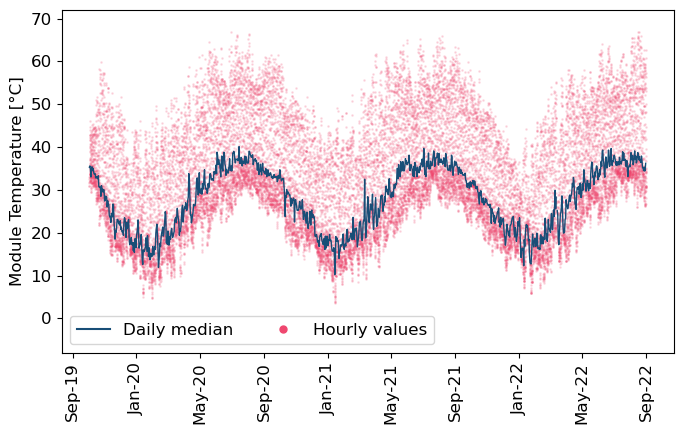

In [26]:
# plot the module temperature variation

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 12})

tem_day_mk = mlines.Line2D([], [], color='#184e77', linestyle='-', linewidth=1.5, label='Daily median')
temp_mk = mlines.Line2D([], [], color='#ef476f', marker='.', linestyle='',markersize=10, label='Hourly values')


xformatter = mdates.DateFormatter('%b-%y')

fig, ax = plt.subplots(figsize=(7,4.5))

plt.scatter(temp_data_hr['ts_dH'], temp_data_hr['tm_mono_soil_all'], s=1, alpha=0.15, color='#ef476f')
plt.plot(temp_data_day['date'], temp_data_day['tm_mono_soil_all'], color='#184e77', linewidth=1)


ax.legend(handles=[tem_day_mk, temp_mk], loc=3,ncol=2)
ax.set_ylabel('Module Temperature [°C]')
ax.set_ylim([-8, 72])

ax.xaxis.set_major_formatter(xformatter)

plt.xticks(rotation='vertical')
fig.tight_layout()

fig.savefig('./Figures/5.mod_temp.tif')
fig.savefig('./Figures/5.mod_temp.svg')



##### -  PV data: monofacial comparison

      MPP_mono_clean_all               MPP_mono_soil_all              
                    mean         count              mean         count
count       12953.000000  25584.000000      13039.000000  25584.000000
mean          114.445924     28.079190         90.115057     28.262391
std            70.864304     29.068469         62.854573     29.078326
min             4.015000      0.000000          1.656500      0.000000
25%            43.706567      0.000000         30.479625      0.000000
50%           125.958933      5.000000         86.015317      7.000000
75%           180.386900     60.000000        139.201542     60.000000
max           287.532817     60.000000        245.517067     60.000000


Text(0.5, 1.0, 'monofacial')

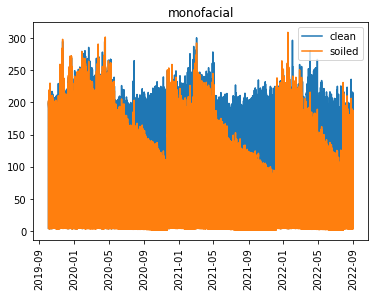

In [27]:
variables = ['MPP_mono_clean_all', 'MPP_mono_soil_all']

monofac = data[['timestamp','G_POA_4']+variables].copy(deep=True).sort_values(by='timestamp').reset_index(drop=True)

### Filter out incorrect PV power observations
for var in variables:
    
    # remove negative values
    monofac.loc[monofac[var] <= 1, var] = np.nan

    # remove night values (G_POA < 20 W/m2)
    monofac.loc[monofac['G_POA_4'].fillna(0) < 20, var] = np.nan  
    
monofac.loc[monofac['G_POA_4'].fillna(0) < 20, 'G_POA_4'] = np.nan

# create a temp variable to hold only the date and hour information
monofac['ts_dH'] = monofac['timestamp'].dt.floor('H')

# calculate the hourly mean and the number of obs per hour for each module variable
monofac_hr = monofac[['ts_dH']+variables].groupby(by='ts_dH', as_index=False).agg(['mean', 'count'])
monofac_hr['ts_dH'] = monofac_hr.index.values
monofac_hr = monofac_hr.reset_index(drop=True)

# print the Summary statistics
print(monofac_hr.describe())

# plot the data for visualization
%matplotlib inline
plt.plot(monofac['timestamp'], monofac['MPP_mono_clean_all'], label='clean')
plt.plot(monofac['timestamp'], monofac['MPP_mono_soil_all'], label='soiled')
plt.xticks(rotation='vertical')
plt.legend(loc=1)
plt.title('monofacial')


In [28]:
# create a suport dataframe where to save all the data used in the analysis
pv_data = data[['timestamp', 'G_POA_4']+variables].copy(deep=True)


In [29]:
# keep only hours for which there are at least 30 observations in all the variables

monofac_hr['keep_row'] = 0

for var in variables:
    
    monofac_hr.loc[monofac_hr[var]['count'] > 30, 'keep_row'] = monofac_hr['keep_row'] + 1

# filter the empty rows
monofac_hr = monofac_hr.loc[monofac_hr['keep_row']> 0].reset_index(drop=True)

Text(0.5, 1.0, 'monofacial')

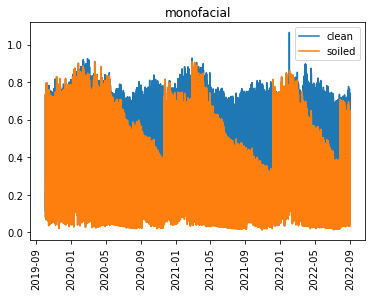

In [30]:
# normalize the values for the nominal Max power of the module (manufacturer)
monofac_EY = pd.DataFrame()
monofac_EY['ts_dH'] = monofac_hr['ts_dH']
for var in variables:
    monofac_EY[var] = monofac_hr[var]['mean'] / 270

# add date
monofac_EY['date'] = monofac_EY['ts_dH'].dt.date

# plot the data for visualization
%matplotlib inline
plt.plot(monofac_EY['ts_dH'], monofac_EY['MPP_mono_clean_all'], label='clean')
plt.plot(monofac_EY['ts_dH'], monofac_EY['MPP_mono_soil_all'], label='soiled')
plt.xticks(rotation='vertical')
plt.legend(loc=1, fontsize=10)
plt.title('monofacial')

In [31]:
# create a suport dataframe where to save all the hourly data used in the analysis
pv_data_hr = monofac_EY[['ts_dH']+variables].copy(deep=True).rename(columns={'ts_dH':'timestamp'})

      MPP_mono_clean_all              MPP_mono_soil_all             
                     sum        count               sum        count
count        1053.000000  1053.000000       1053.000000  1053.000000
mean            5.180335    11.403609          4.105718    11.472934
std             0.917987     1.632450          1.129579     1.379673
min             0.000000     0.000000          0.249204     1.000000
25%             5.007023    10.000000          3.231221    11.000000
50%             5.345401    11.000000          4.252874    11.000000
75%             5.656970    13.000000          5.005548    13.000000
max             6.887030    13.000000          6.527491    13.000000


Text(0.5, 1.0, 'monofacial')

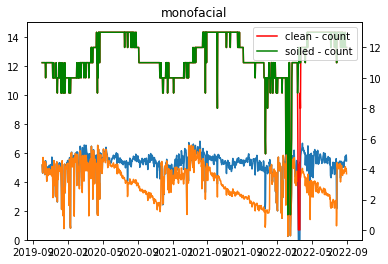

In [32]:
# calculate daily energy yield as sum of the daily contributions
monofac_EY_day = monofac_EY[['date']+variables].groupby(by='date', as_index=False).agg(['sum', 'count'])
monofac_EY_day['date'] = monofac_EY_day.index.values
monofac_EY_day = monofac_EY_day.reset_index(drop=True)

# print the Summary statistics
print(monofac_EY_day.describe())

# plot the data for visualization
%matplotlib inline
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot daily energy
ax1.plot(monofac_EY_day['date'], monofac_EY_day['MPP_mono_clean_all']['sum'], label='clean - daily EY')
ax1.plot(monofac_EY_day['date'], monofac_EY_day['MPP_mono_soil_all']['sum'], label='soiled - daily EY')


# plot daily energy
ax2.plot(monofac_EY_day['date'], monofac_EY_day['MPP_mono_clean_all']['count'], label='clean - count', color='red')
ax2.plot(monofac_EY_day['date'], monofac_EY_day['MPP_mono_soil_all']['count'], label='soiled - count', color='green')


ax1.set_ylim([0,15])
plt.xticks(rotation='vertical')
plt.legend(loc=1)
plt.title('monofacial')


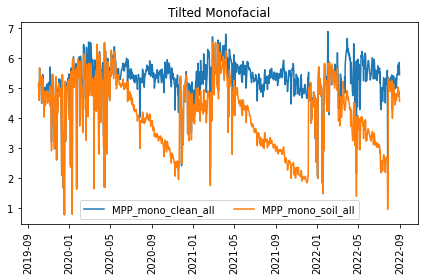

In [33]:
# keep only days for which there are at least 8 hours

monofac_EY_day['keep_row'] = 0

for var in variables:
    
    monofac_EY_day.loc[monofac_EY_day[var]['count'] > 8, 'keep_row'] = monofac_EY_day['keep_row'] + 1

# filter the empty rows
monofac_EY_day = monofac_EY_day.loc[monofac_EY_day['keep_row']> 0].reset_index(drop=True)

# set to nan all sums = 0
for var in variables:
    monofac_EY_day.loc[monofac_EY_day[var]['sum'] == 0, var] = np.nan


# normalize the values for the nominal Max power of the module (manufacturer)
temp = pd.DataFrame()
temp['date'] = monofac_EY_day['date']
for var in variables:
    temp[var] = monofac_EY_day[var]['sum']

# substitute monofac_EY_day
monofac_EY_day = temp.copy(deep=True)

# plot the data for visualization
%matplotlib inline
for var in variables:
    plt.plot(temp['date'], temp[var], label=var)
plt.legend(ncol=2)
plt.title('Tilted Monofacial')
plt.xticks(rotation='vertical')
plt.tight_layout()

In [34]:
# create a suport dataframe where to save all the daily data used in the analysis
pv_data_day = monofac_EY_day.copy(deep=True)

In [35]:
# add a temp variable to calculate the monthly statistics
monofac_EY_day['ts_YM'] = pd.to_datetime(monofac_EY_day['date']).dt.strftime("%b-%y")

In [36]:
# melt the dataset for boxplot
box_plot_data = monofac_EY_day[['ts_YM']+variables].melt(id_vars=['ts_YM'], 
                                                     var_name='Conditions', value_name='Normalized Power (W/Wp)')


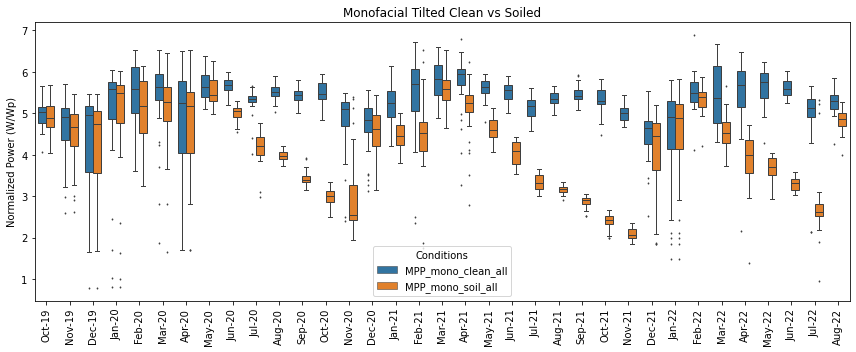

In [37]:
#plot the monthly variation

%matplotlib inline
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=box_plot_data, y='Normalized Power (W/Wp)', ax=ax, x='ts_YM', hue='Conditions',dodge=True,
            width=0.7,fliersize=1,linewidth=1)

plt.xticks(rotation='vertical')
plt.xlabel('')

#fig.autofmt_xdate(rotation=90)
plt.title('Monofacial Tilted Clean vs Soiled')

#ax.xaxis.set_major_formatter(xformatter)

fig.tight_layout()

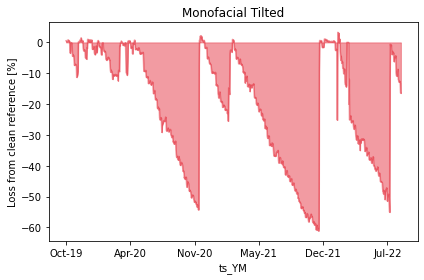

In [38]:
#plot the relative difference in EY between clean and soiled - monofacial module

%matplotlib inline

monofac_EY_day['diff'] = (monofac_EY_day['MPP_mono_soil_all']-monofac_EY_day['MPP_mono_clean_all'])/monofac_EY_day['MPP_mono_clean_all']*100

monofac_EY_day.loc[monofac_EY_day['diff'] > 5,'diff'] = np.nan

#plt.plot((monofac_EY['soiled']-monofac_EY['clean'])/monofac_EY['clean']*100)
monofac_EY_day.plot.area(x = 'ts_YM', y='diff',stacked=False, legend=False, color='#e63946')
plt.ylabel('Loss from clean reference [%]')
plt.title('Monofacial Tilted')
plt.tight_layout()

##### bifacial tilted comparison

Text(0.5, 1.0, 'bifacial')

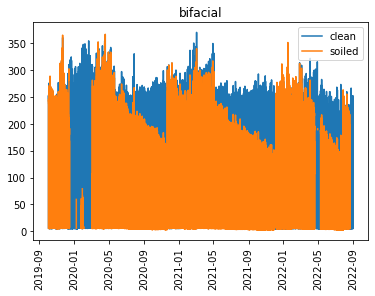

In [39]:
variables = [ 'MPP_bf_tilt_clean_all', 'MPP_bf_tilt_soil_all'] 

bifac_tilt = data[['timestamp','G_POA_4']+variables].copy(deep=True).sort_values(by='timestamp').reset_index(drop=True)

### Filter out wrong PV power observations

for var in variables:
    # remove negative values
    bifac_tilt.loc[bifac_tilt[var] <= 1, var] = np.nan

    # remove night values (G_POA < 20 W/m2)
    bifac_tilt.loc[bifac_tilt['G_POA_4'].fillna(0) < 20, var] = np.nan  
    
bifac_tilt.loc[bifac_tilt['G_POA_4'].fillna(0) < 20, 'G_POA_4'] = np.nan  

# create a temp variable to hold only the date and hour information
bifac_tilt['ts_dH'] = bifac_tilt['timestamp'].dt.floor('H')

# plot the data for visualization
%matplotlib inline
plt.plot(bifac_tilt['timestamp'], bifac_tilt['MPP_bf_tilt_clean_all'], label='clean')
plt.plot(bifac_tilt['timestamp'], bifac_tilt['MPP_bf_tilt_soil_all'], label='soiled')
plt.xticks(rotation='vertical')
plt.legend(loc=1)
plt.title('bifacial')



In [40]:
## add the data to the pv_data support DataFrame
pv_data = pv_data.merge(bifac_tilt, on='timestamp', how='outer')

pv_data['G_POA_4'] = pv_data['G_POA_4_x'].values
pv_data.loc[pd.isna(pv_data['G_POA_4']), 'G_POA_4'] = pv_data['G_POA_4_y']

pv_data = pv_data[['timestamp','G_POA_4','MPP_mono_clean_all', 'MPP_mono_soil_all',
                   'MPP_bf_tilt_clean_all', 'MPP_bf_tilt_soil_all']]

In [41]:
# calculate the hourly mean and the number of obs per hour for each module variable
bifac_tilt_hr = bifac_tilt[['ts_dH']+variables].groupby(by='ts_dH', as_index=False).agg(['mean', 'count'])
bifac_tilt_hr['ts_dH'] = bifac_tilt_hr.index.values
bifac_tilt_hr = bifac_tilt_hr.reset_index(drop=True)

# print the Summary statistics
bifac_tilt_hr.describe()

MPP_bf_tilt_clean_all               MPP_bf_tilt_soil_all              
                       mean         count                 mean         count
count          13057.000000  25584.000000         11281.000000  25584.000000
mean             143.830910     28.302650           120.198446     24.362179
std               86.998349     29.079224            76.990130     28.683437
min                4.569000      0.000000             3.049000      0.000000
25%               60.431400      0.000000            47.734167      0.000000
50%              155.471333      8.000000           122.824117      0.000000
75%              224.713700     60.000000           183.206667     60.000000
max              305.305867     60.000000           297.020017     60.000000

In [42]:
# keep only hours for which there are at least 30 observations in all the variables

bifac_tilt_hr['keep_row'] = 0

for var in variables:
    
    bifac_tilt_hr.loc[bifac_tilt_hr[var]['count'] > 30, 'keep_row'] = bifac_tilt_hr['keep_row'] + 1

# filter the empty rows
bifac_tilt_hr = bifac_tilt_hr.loc[bifac_tilt_hr['keep_row']> 0].reset_index(drop=True)

Text(0.5, 1.0, 'bifacial')

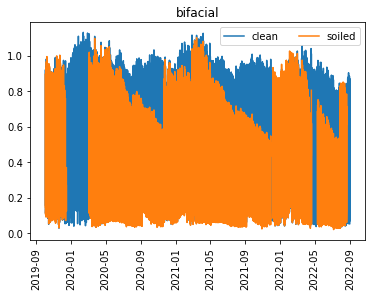

In [43]:
# normalize the values for the nominal Max power of the module (manufacturer)
bifac_tilt_EY = pd.DataFrame()
bifac_tilt_EY['ts_dH'] = bifac_tilt_hr['ts_dH']
for var in variables:
    bifac_tilt_EY[var] = bifac_tilt_hr[var]['mean'] / 270

# add date
bifac_tilt_EY['date'] = bifac_tilt_EY['ts_dH'].dt.date

# plot the data for visualization
%matplotlib inline
plt.plot(bifac_tilt_EY['ts_dH'], bifac_tilt_EY['MPP_bf_tilt_clean_all'], label='clean')
plt.plot(bifac_tilt_EY['ts_dH'], bifac_tilt_EY['MPP_bf_tilt_soil_all'], label='soiled')
plt.xticks(rotation='vertical')
plt.legend(loc=1, ncol=2, fontsize=10)
plt.title('bifacial')


In [44]:
## add bifac_tilt_EY to the hourly pv_data support DataFrame

bifac_tilt_EY['timestamp'] = pd.to_datetime(bifac_tilt_EY['ts_dH'])

pv_data_hr = pv_data_hr.merge(bifac_tilt_EY[['timestamp', 'MPP_bf_tilt_clean_all', 'MPP_bf_tilt_soil_all']], 
                              on='timestamp', how='outer')


      MPP_bf_tilt_clean_all              MPP_bf_tilt_soil_all             
                        sum        count                  sum        count
count           1054.000000  1054.000000          1054.000000  1054.000000
mean               6.554895    11.478178             4.733412     9.919355
std                1.111200     1.362571             2.182057     4.062445
min                0.295613     1.000000             0.000000     0.000000
1%                 2.314405     9.000000             0.000000     0.000000
2%                 2.890811     9.000000             0.000000     0.000000
25%                6.141445    11.000000             3.975160    10.000000
50%                6.803223    11.000000             5.366845    11.000000
75%                7.231800    13.000000             6.244344    13.000000
max                8.687818    13.000000             8.114524    13.000000


Text(0.5, 1.0, 'bifacial')

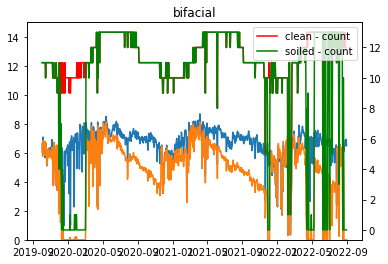

In [45]:
# calculate daily energy yield
bifac_tilt_EY_day = bifac_tilt_EY[['date']+variables].groupby(by='date', as_index=False).agg(['sum', 'count'])
bifac_tilt_EY_day['date'] = bifac_tilt_EY_day.index.values
bifac_tilt_EY_day = bifac_tilt_EY_day.reset_index(drop=True)

# print the Summary statistics
print(bifac_tilt_EY_day.describe(percentiles = [.01, .02, .25, .5, .75]))

# plot the data for visualization
%matplotlib inline
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot daily energy
ax1.plot(bifac_tilt_EY_day['date'], bifac_tilt_EY_day['MPP_bf_tilt_clean_all']['sum'], label='clean - daily EY')
ax1.plot(bifac_tilt_EY_day['date'], bifac_tilt_EY_day['MPP_bf_tilt_soil_all']['sum'], label='soiled - daily EY')


# plot daily energy
ax2.plot(bifac_tilt_EY_day['date'], bifac_tilt_EY_day['MPP_bf_tilt_clean_all']['count'], label='clean - count', color='red')
ax2.plot(bifac_tilt_EY_day['date'], bifac_tilt_EY_day['MPP_bf_tilt_soil_all']['count'], label='soiled - count', color='green')


ax1.set_ylim([0,15])
plt.xticks(rotation='vertical')
plt.legend(loc=1)
plt.title('bifacial')



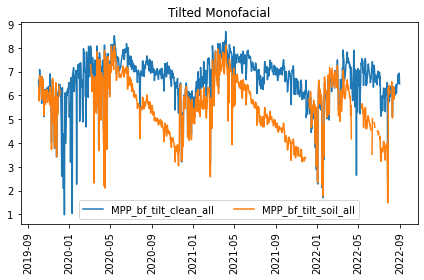

In [46]:
# keep only days for which there are at least 8 hours

bifac_tilt_EY_day['keep_row'] = 0

for var in variables:
    
    bifac_tilt_EY_day.loc[bifac_tilt_EY_day[var]['count'] > 8, 'keep_row'] = bifac_tilt_EY_day['keep_row'] + 1
    
    bifac_tilt_EY_day.loc[bifac_tilt_EY_day[var]['count'] <= 8, var] = np.nan

# filter the empty rows
bifac_tilt_EY_day = bifac_tilt_EY_day.loc[bifac_tilt_EY_day['keep_row']> 0].reset_index(drop=True)

# set to nan all sums = 0
for var in variables:
    bifac_tilt_EY_day.loc[bifac_tilt_EY_day[var]['sum'] == 0, var] = np.nan


# normalize the values for the nominal Max power of the module (manufacturer)
temp = pd.DataFrame()
temp['date'] = bifac_tilt_EY_day['date']
for var in variables:
    temp[var] = bifac_tilt_EY_day[var]['sum']

# substitute monofac_EY_day
bifac_tilt_EY_day = temp.copy(deep=True)

# plot the data for visualization
%matplotlib inline
for var in variables:
    plt.plot(temp['date'], temp[var], label=var)
plt.legend(ncol=2)
plt.title('Tilted Monofacial')
plt.xticks(rotation='vertical')
plt.tight_layout()

In [47]:
## add daily bifac_tilt_EY to the daily pv_data support DataFrame
pv_data_day = pv_data_day.merge(bifac_tilt_EY, on='date', how='outer')


In [48]:
# add a temp variable to calculate the monthly statistics
bifac_tilt_EY_day['ts_YM'] = pd.to_datetime(bifac_tilt_EY_day['date']).dt.strftime("%b-%y")


In [49]:
# melt the dataset for boxplot
box_plot_data_bft = bifac_tilt_EY_day[['ts_YM']+variables].rename(columns={
    "MPP_bf_tilt_clean_all": "clean",
    "MPP_bf_tilt_soil_all": "soiled"}).melt(id_vars=['ts_YM'], var_name='Conditions', 
                                                                   value_name='Specific Energy Yield (Wh/Wp)')

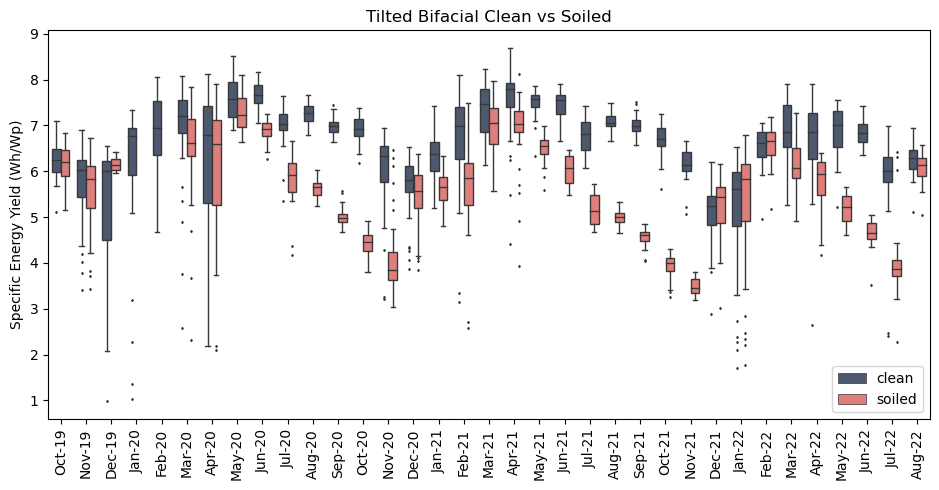

In [50]:
#plot the monthly variation

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

my_pal = {"clean": "#465775", "soiled":"#ef6f6c"}

fig, ax = plt.subplots(figsize=(9.5,5))
sns.boxplot(data=box_plot_data_bft, y='Specific Energy Yield (Wh/Wp)', ax=ax, x='ts_YM', hue='Conditions',dodge=True,
            width=0.7,fliersize=1,linewidth=1, palette=my_pal)

plt.xticks(rotation='vertical')
plt.xlabel('')

plt.legend(loc=4)
plt.title('Tilted Bifacial Clean vs Soiled')
fig.tight_layout()

fig.savefig('./Figures/6.bif_clean_soil.tif')
fig.savefig('./Figures/6.bif_clean_soil.svg')

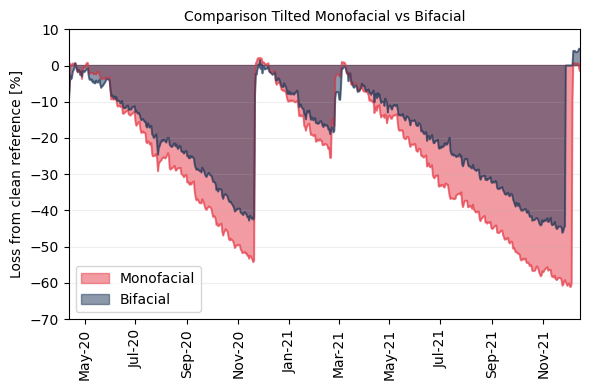

In [51]:
#plot the relative difference in EY between clean and soiled - monofacial and bifacial tilted modules

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(6,4))

xformatter = mdates.DateFormatter('%b-%y')

monofac_EY_day['monofacial'] = (monofac_EY_day['MPP_mono_soil_all']-monofac_EY_day['MPP_mono_clean_all'])/monofac_EY_day['MPP_mono_clean_all']*100

bifac_tilt_EY_day['bifacial'] = (bifac_tilt_EY_day['MPP_bf_tilt_soil_all']-
                                 bifac_tilt_EY_day['MPP_bf_tilt_clean_all'])/bifac_tilt_EY_day['MPP_bf_tilt_clean_all']*100

bifac_tilt_EY_day.loc[bifac_tilt_EY_day.loc[np.abs(bifac_tilt_EY_day['bifacial'].fillna(0).diff(-1) > 10)].index+1, 'bifacial'] = np.nan

monofac_EY_day.plot.area(x = 'date', y='monofacial',stacked=False, color='#e63946', ax=ax, label='Monofacial')
bifac_tilt_EY_day.plot.area(x = 'date', y='bifacial',stacked=False, color='#1d3557', ax=ax, label='Bifacial')
ax.legend(loc=3)

ax.set_xlim([pd.to_datetime('2020-04-12'), pd.to_datetime('2021-12-15')])
#ax.set_xlim([pd.to_datetime('2020-04-12'), pd.to_datetime('2022-08-01')])

ax.set_ylim([-70,10])
ax.grid(axis='y', alpha=0.2)
ax.set_xlabel('')


ax.set_ylabel('Loss from clean reference [%]')
ax.set_title('Comparison Tilted Monofacial vs Bifacial', fontsize=10)

ax.xaxis.set_major_formatter(xformatter)

plt.xticks(rotation='vertical')

fig.tight_layout()

# full with 2022 data

#fig.savefig('./Figures/7.loss_mono_bif_full.tif')
#fig.savefig('./Figures/7.loss_mono_bif_full.svg')

fig.savefig('./Figures/7.loss_mono_bif.tif')
fig.savefig('./Figures/7.loss_mono_bif.svg')

##### bifacial vertical PV

Text(0.5, 1.0, 'bifacial')

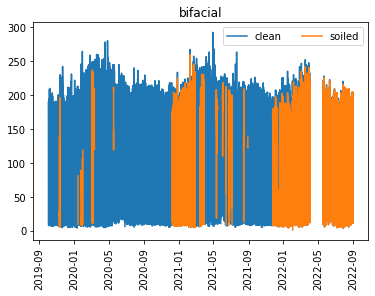

In [52]:
variables = [  'MPP_bf_EW_clean_all', 'MPP_bf_EW_soil_all'] 

bifac_vert = data[['timestamp','G_POA_4','G_vert_E','G_vert_W']+variables].copy(deep=True).sort_values(by='timestamp').reset_index(drop=True)

### Filter out incorrect PV power observations

bifac_vert['timestamp'] = pd.to_datetime(bifac_vert['timestamp'])

for var in variables:
    # remove negative values
    bifac_vert.loc[bifac_vert[var] <= 1, var] = np.nan

    # remove night values (G_POA < 20 W/m2)
    bifac_vert.loc[bifac_vert['G_POA_4'].fillna(0) < 20, var] = np.nan  
    
bifac_vert.loc[bifac_vert['G_POA_4'].fillna(0) < 20, 'G_POA_4'] = np.nan

# create a temp variable to hold only the date and hour information
bifac_vert['ts_dH'] = bifac_vert['timestamp'].dt.floor('H')

# plot the data for visualization
%matplotlib inline
plt.plot(bifac_vert['timestamp'], bifac_vert['MPP_bf_EW_clean_all'], label='clean')
plt.plot(bifac_vert['timestamp'], bifac_vert['MPP_bf_EW_soil_all'], label='soiled')
plt.xticks(rotation='vertical')
plt.legend(loc=1, ncol=2)
plt.title('bifacial')

Text(0.5, 1.0, 'bifacial')

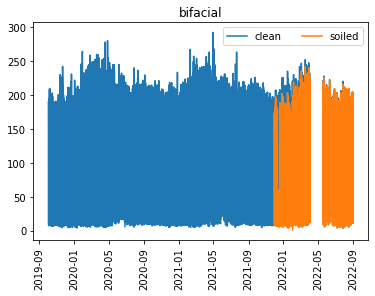

In [53]:
# remove soiled data before 29/11/2021
bifac_vert.loc[bifac_vert['timestamp'] < pd.to_datetime('29 nov 2021'), 'MPP_bf_EW_soil_all'] = np.nan

# plot the data for visualization
%matplotlib inline
plt.plot(bifac_vert['timestamp'], bifac_vert['MPP_bf_EW_clean_all'], label='clean')
plt.plot(bifac_vert['timestamp'], bifac_vert['MPP_bf_EW_soil_all'], label='soiled')
plt.xticks(rotation='vertical')
plt.legend(loc=1, ncol=2)
plt.title('bifacial')

In [54]:
## add the data to the pv_data support DataFrame
pv_data = pv_data.merge(bifac_vert, on='timestamp', how='outer')

pv_data['G_POA_4'] = pv_data['G_POA_4_x'].values
pv_data.loc[pd.isna(pv_data['G_POA_4']), 'G_POA_4'] = pv_data['G_POA_4_y']

pv_data = pv_data[['timestamp', 'G_POA_4', 'G_vert_E', 'G_vert_W','MPP_mono_clean_all', 'MPP_mono_soil_all',
       'MPP_bf_tilt_clean_all', 'MPP_bf_tilt_soil_all','MPP_bf_EW_clean_all', 'MPP_bf_EW_soil_all']]


In [55]:
# calculate the hourly mean and the number of obs per hour for each module variable
bifac_vert_hr = bifac_vert[['ts_dH']+variables].groupby(by='ts_dH', as_index=False).agg(['mean', 'count'])
bifac_vert_hr['ts_dH'] = bifac_vert_hr.index.values
bifac_vert_hr = bifac_vert_hr.reset_index(drop=True)

# print the Summary statistics
bifac_vert_hr.describe()

MPP_bf_EW_clean_all               MPP_bf_EW_soil_all              
                     mean         count               mean         count
count        12325.000000  25584.000000        2387.000000  25584.000000
mean           139.731703     26.670458         130.164048      5.137547
std             56.698041     28.985618          54.797886     16.486448
min              4.448000      0.000000           2.871958      0.000000
25%            111.416583      0.000000          99.526739      0.000000
50%            153.791933      0.000000         144.687783      0.000000
75%            183.121750     60.000000         170.060592      0.000000
max            252.060783     60.000000         238.362667     60.000000

In [56]:
# keep only hours for which there are at least 30 observations in all the variables

bifac_vert_hr['keep_row'] = 0

for var in variables:
    
    bifac_vert_hr.loc[bifac_vert_hr[var]['count'] > 30, 'keep_row'] = bifac_vert_hr['keep_row'] + 1

# filter the empty rows
bifac_vert_hr = bifac_vert_hr.loc[bifac_vert_hr['keep_row']> 0].reset_index(drop=True)

Text(0.5, 1.0, 'bifacial')

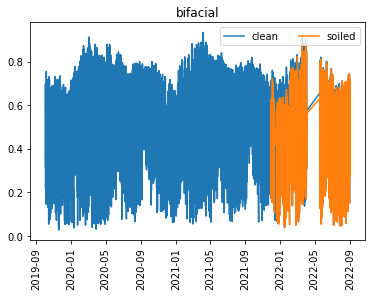

In [57]:
# normalize the values for the nominal Max power of the module (manufacturer)
bifac_vert_EY = pd.DataFrame()
bifac_vert_EY['ts_dH'] = bifac_vert_hr['ts_dH']
for var in variables:
    bifac_vert_EY[var] = bifac_vert_hr[var]['mean'] / 270

# add date
bifac_vert_EY['date'] = bifac_vert_EY['ts_dH'].dt.date

# plot the data for visualization
%matplotlib inline
plt.plot(bifac_vert_EY['ts_dH'], bifac_vert_EY['MPP_bf_EW_clean_all'], label='clean')
plt.plot(bifac_vert_EY['ts_dH'], bifac_vert_EY['MPP_bf_EW_soil_all'], label='soiled')
plt.xticks(rotation='vertical')
plt.legend(loc=1, ncol=2, fontsize=10)
plt.title('bifacial')


In [58]:
## add bifac_vert_EY to the hourly pv_data support DataFrame

bifac_vert_EY['timestamp'] = pd.to_datetime(bifac_vert_EY['ts_dH'])

pv_data_hr = pv_data_hr.merge(bifac_vert_EY[['timestamp', 'MPP_bf_EW_clean_all', 'MPP_bf_EW_soil_all']], 
                              on='timestamp', how='outer')


      MPP_bf_EW_clean_all              MPP_bf_EW_soil_all             
                      sum        count                sum        count
count         1002.000000  1002.000000        1002.000000  1002.000000
mean             6.268160    11.362275           1.129292     2.204591
std              1.399694     1.517627           2.385989     4.548667
min              0.365283     1.000000           0.000000     0.000000
1%               1.810682     6.000000           0.000000     0.000000
2%               2.474684     9.000000           0.000000     0.000000
25%              5.412276    10.000000           0.000000     0.000000
50%              6.499451    11.000000           0.000000     0.000000
75%              7.291522    13.000000           0.000000     0.000000
80%              7.469191    13.000000           0.281179     1.000000
99%              8.552850    13.000000           7.778609    13.000000
max              8.969025    13.000000           8.262440    13.000000


Text(0.5, 1.0, 'vertical bifacial')

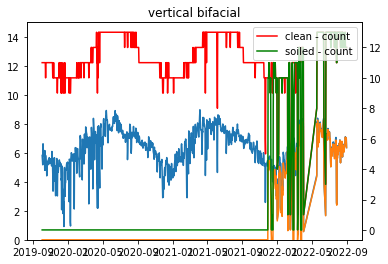

In [59]:
# calculate daily energy yield
bifac_vert_EY_day = bifac_vert_EY[['date']+variables].groupby(by='date', as_index=False).agg(['sum', 'count'])
bifac_vert_EY_day['date'] = bifac_vert_EY_day.index.values
bifac_vert_EY_day = bifac_vert_EY_day.reset_index(drop=True)

# print the Summary statistics
print(bifac_vert_EY_day.describe(percentiles = [.01, .02, .25, .5, .75, .8, .99]))

# plot the data for visualization
%matplotlib inline
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot daily energy
ax1.plot(bifac_vert_EY_day['date'], bifac_vert_EY_day['MPP_bf_EW_clean_all']['sum'], label='clean - daily EY')
ax1.plot(bifac_vert_EY_day['date'], bifac_vert_EY_day['MPP_bf_EW_soil_all']['sum'], label='soiled - daily EY')


# plot daily energy
ax2.plot(bifac_vert_EY_day['date'], bifac_vert_EY_day['MPP_bf_EW_clean_all']['count'], label='clean - count', color='red')
ax2.plot(bifac_vert_EY_day['date'], bifac_vert_EY_day['MPP_bf_EW_soil_all']['count'], label='soiled - count', color='green')


ax1.set_ylim([0,15])
plt.xticks(rotation='vertical')
plt.legend(loc=1)
plt.title('vertical bifacial')


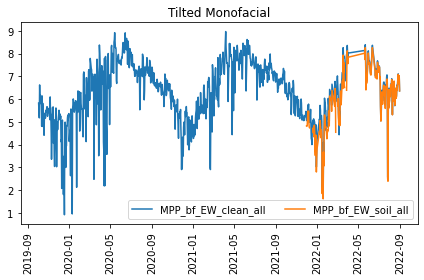

In [60]:
# keep only days for which there are at least 8 hours

bifac_vert_EY_day['keep_row'] = 0

for var in variables:
    
    bifac_vert_EY_day.loc[bifac_vert_EY_day[var]['count'] > 8, 'keep_row'] = bifac_vert_EY_day['keep_row'] + 1
    
    bifac_vert_EY_day.loc[bifac_vert_EY_day[var]['count'] <= 8, var] = np.nan

# filter the empty rows
bifac_vert_EY_day = bifac_vert_EY_day.loc[bifac_vert_EY_day['keep_row']> 0].reset_index(drop=True)

# set to nan all sums = 0
for var in variables:
    bifac_vert_EY_day.loc[bifac_vert_EY_day[var]['sum'] == 0, var] = np.nan


# normalize the values for the nominal Max power of the module (manufacturer)
temp = pd.DataFrame()
temp['date'] = bifac_vert_EY_day['date']
for var in variables:
    temp[var] = bifac_vert_EY_day[var]['sum']

# substitute monofac_EY_day
bifac_vert_EY_day = temp.copy(deep=True)

# plot the data for visualization
%matplotlib inline
for var in variables:
    plt.plot(temp['date'], temp[var], label=var)
plt.legend(ncol=2)
plt.title('Tilted Monofacial')
plt.xticks(rotation='vertical')
plt.tight_layout()

In [61]:
## add daily bifac_vert_EY_day to the daily pv_data support DataFrame
pv_data_day = pv_data_day.merge(bifac_vert_EY, on='date', how='outer')


In [62]:
# add a temp variable to calculate the monthly statistics
bifac_vert_EY_day['ts_YM'] = pd.to_datetime(bifac_vert_EY_day['date']).dt.strftime("%b-%y")

# add a temp variable to calculate the monthly statistics
bifac_vert_EY_day['ts_YM_2'] = pd.to_datetime(bifac_vert_EY_day['date']).dt.strftime("%Y-%m")


In [63]:
# melt the dataset for boxplot

box_plot_data_bfv = bifac_vert_EY_day[['ts_YM','MPP_bf_EW_clean_all','MPP_bf_EW_soil_all']].rename(columns={
    "MPP_bf_EW_clean_all": "clean",
    "MPP_bf_EW_soil_all": "soiled"}).melt(
    id_vars=['ts_YM'], var_name='conditions', value_name='Normalized Power (W/Wp)')


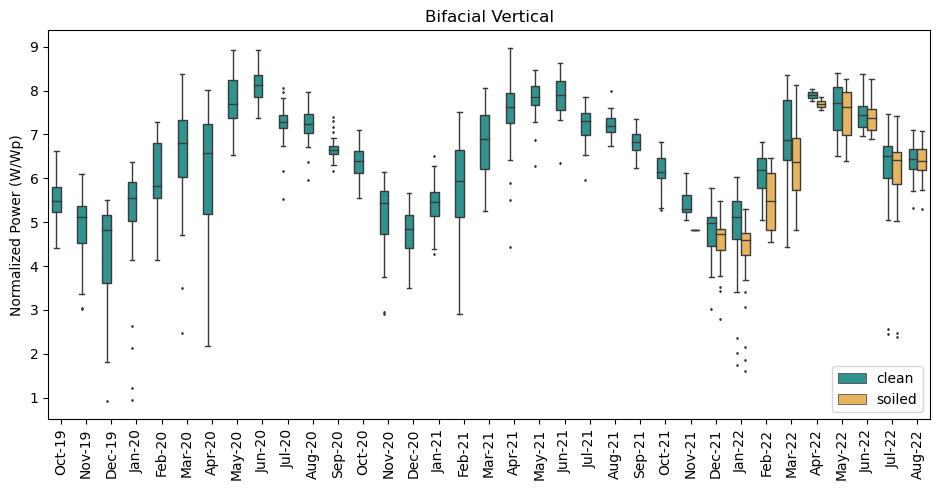

In [64]:
#plot the monthly variation

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

my_pal = {"clean": "#20a39e", "soiled":"#ffba49"}

fig, ax = plt.subplots(figsize=(9.5,5))
sns.boxplot(data=box_plot_data_bfv, y='Normalized Power (W/Wp)', ax=ax, x='ts_YM', hue='conditions',dodge=True,
            width=0.7,fliersize=1,linewidth=1, palette=my_pal)

plt.xticks(rotation='vertical')
plt.xlabel('')

ax.legend(loc=4)

plt.title('Bifacial Vertical')
fig.tight_layout()

fig.savefig('./Figures/8.vertbif_clean_soil.tif')
fig.savefig('./Figures/8.vertbif_clean_soil.svg')


In [65]:
# calculate % difference
bifac_vert_EY_day['diff'] = (bifac_vert_EY_day['MPP_bf_EW_soil_all'] - 
                         bifac_vert_EY_day['MPP_bf_EW_clean_all'])/(bifac_vert_EY_day['MPP_bf_EW_clean_all'])*100

C:\Users\gscabbia\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


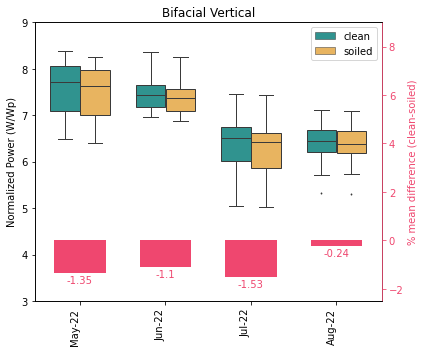

In [66]:
# melt the dataset for boxplot
box_plot_data_bfv = bifac_vert_EY_day.loc[(pd.to_datetime(bifac_vert_EY_day['ts_YM_2']).dt.date >= pd.to_datetime('01 may 2022')),
                                          ['ts_YM','MPP_bf_EW_clean_all','MPP_bf_EW_soil_all']].dropna().melt(
    id_vars=['ts_YM'], var_name='conditions', value_name='Normalized Power (W/Wp)')

df = bifac_vert_EY_day.loc[
    (pd.to_datetime(bifac_vert_EY_day['ts_YM_2']).dt.date >= pd.to_datetime('01 may 2022')), 
    ['ts_YM','diff']].groupby(by='ts_YM', as_index=False).mean().sort_values(by='ts_YM', 
                                                                             ascending=False).reset_index(drop=True)

df['diff'] = np.round(df['diff'],2)

box_plot_data_bfv.loc[box_plot_data_bfv['conditions'] == 'MPP_bf_EW_clean_all', 'conditions'] = 'clean'
box_plot_data_bfv.loc[box_plot_data_bfv['conditions'] == 'MPP_bf_EW_soil_all', 'conditions'] = 'soiled'

#plot the monthly variation - zoomed
%matplotlib inline

import seaborn as sns

fig, ax = plt.subplots(figsize=(6,5))

my_pal = {"clean": "#20a39e", "soiled":"#ffba49"}

sns.boxplot(data=box_plot_data_bfv,
            y='Normalized Power (W/Wp)', ax=ax, x='ts_YM', hue='conditions',dodge=True,
            width=0.7,fliersize=1,linewidth=1, palette=my_pal)


ax.set_xlabel('')
ax.set_title('Bifacial Vertical')

ax.legend(loc=1)

ax.set_ylim([3,9])

ax2 = ax.twinx()
bars = ax2.bar(df['ts_YM'],df['diff'], color='#ef476f', width=0.6)

ax2.set_ylim([-2.5,9])

ax2.bar_label(bars, padding=2, color='#ef476f')

ax2.tick_params(axis='y', colors='#ef476f')
ax2.spines['right'].set_color('#ef476f')
ax2.set_ylabel('% mean difference (clean-soiled)', color='#ef476f')

fig.autofmt_xdate(rotation='vertical' )

fig.tight_layout()

fig.savefig('./Figures/8.vertbif_clean_soil_zoom.tif')
fig.savefig('./Figures/8.vertbif_clean_soil_zoom.svg')

C:\Users\gscabbia\AppData\Local\Temp\1/ipykernel_44768/3833229592.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bifac_vert_EY_day.loc[pd.to_datetime(bifac_vert_EY_day['date']) > pd.to_datetime('01 may 2022')].mean()


MPP_bf_EW_clean_all    6.740602
MPP_bf_EW_soil_all     6.674514
diff                  -0.991051
dtype: float64

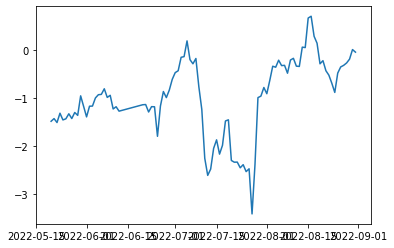

In [88]:
%matplotlib inline
plt.plot(bifac_vert_EY_day.loc[pd.to_datetime(bifac_vert_EY_day['date']) > pd.to_datetime('01 may 2022')]['date'], 
         bifac_vert_EY_day.loc[pd.to_datetime(bifac_vert_EY_day['date']) > pd.to_datetime('01 may 2022')]['diff'])

bifac_vert_EY_day.loc[pd.to_datetime(bifac_vert_EY_day['date']) > pd.to_datetime('01 may 2022')].mean()

In [68]:
# save the data 

pv_data = pv_data.loc[~pd.isna(pv_data[list(pv_data.columns[1:])]).all(axis=1)].reset_index(drop=True)

pv_data.to_csv('./data/pv_data'+last_date+'.csv')


In [69]:
# save the hourly data 

pv_data_hr = pv_data_hr.loc[~pd.isna(pv_data_hr[list(pv_data_hr.columns[1:])]).all(axis=1)].reset_index(drop=True)

pv_data_hr.to_csv('./data/hr_pv_data'+last_date+'.csv')


In [70]:
# save the daily data

pv_data_day = pv_data_day.loc[~pd.isna(pv_data_day[list(pv_data_day.columns[1:])]).all(axis=1)].reset_index(drop=True)

pv_data_day.to_csv('./data/day_pv_data'+last_date+'.csv')


In [71]:
### comparison between all clean technologies

clean_mod = monofac_EY_day[['date','MPP_mono_clean_all']].rename(columns={"MPP_mono_clean_all": "monofacial"})
clean_mod = clean_mod.merge(bifac_tilt_EY_day[['date','MPP_bf_tilt_clean_all']], on='date', how='inner').rename(columns={"MPP_bf_tilt_clean_all": "Tilted"})
clean_mod = clean_mod.merge(bifac_vert_EY_day[['date','MPP_bf_EW_clean_all']], on='date', how='inner').rename(columns={"MPP_bf_EW_clean_all": "Vertical"})

clean_mod['ts_YM'] = pd.to_datetime(clean_mod['date']).dt.strftime("%b-%y")

In [72]:
box_plot_data_clean = clean_mod[['ts_YM','Tilted','Vertical']].dropna().melt(id_vars=['ts_YM'], 
                                    var_name='Setting', value_name='Specific Energy Yield (Wh/Wp)')


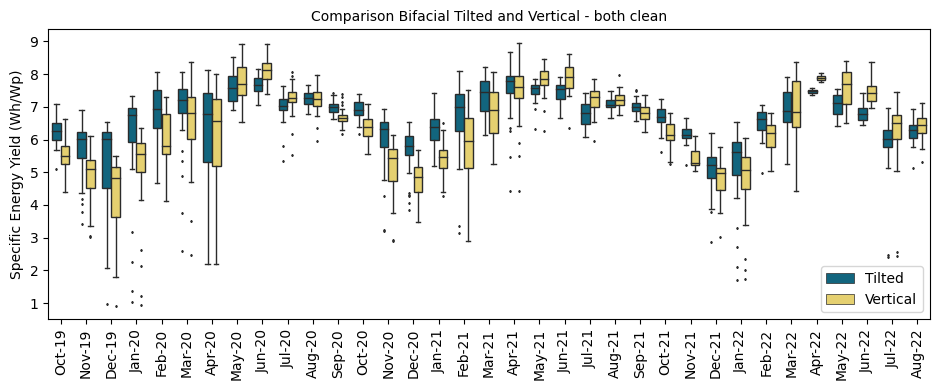

In [73]:
# plot the comparison between tilted bifacial and vertical bifacial (both clean)
%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

my_pal = {"Tilted": "#006e90", "Vertical":"#f9dc5c"}

fig, ax = plt.subplots(figsize=(9.5,4))
sns.boxplot(data=box_plot_data_clean, y='Specific Energy Yield (Wh/Wp)', ax=ax, x='ts_YM', hue='Setting',dodge=True,
            width=0.7,fliersize=1,linewidth=1, palette=my_pal)

plt.xticks(rotation='vertical')
plt.xlabel('')

ax.legend(loc=4)

plt.title('Comparison Bifacial Tilted and Vertical - both clean', fontsize=10)
fig.tight_layout()


fig.savefig('./Figures/9.comparing_bifac.tif')
fig.savefig('./Figures/9.comparing_bifac.svg')

In [74]:
# calculate the % difference between the tilted and the vertical
clean_mod['diff'] = (clean_mod['Vertical'] - clean_mod['Tilted'])/clean_mod['Tilted']*100

# group by the result at monthly level
clean_mod_month = clean_mod[['ts_YM', 'date', 'Tilted','Vertical']].dropna().groupby(by='ts_YM', as_index=False).agg(
{'date':'first', 'Tilted':'sum','Vertical':'sum'}).sort_values(by='date').reset_index(drop=True)

# calculate the monthly difference
clean_mod_month['diff'] = (clean_mod_month['Vertical'] - clean_mod_month['Tilted'])/clean_mod_month['Tilted']*100

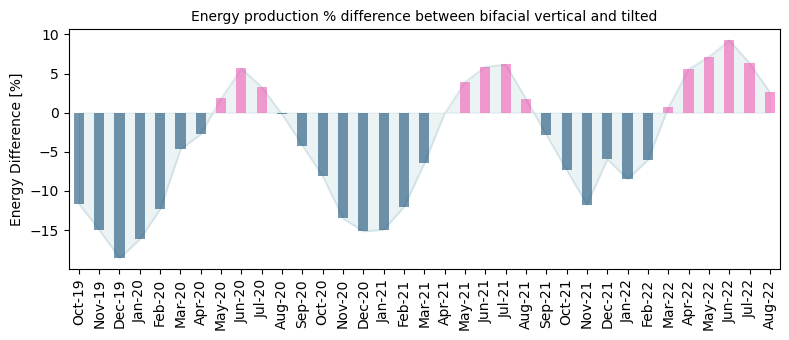

In [75]:
# plot monthly % difference between tilted and vertical bifacial both clean

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(8,3.5))

clean_mod_month['positive'] = clean_mod_month['diff'] > 0

clean_mod_month.plot.area(x = 'ts_YM', y='diff',stacked=False, ax=ax, color='#005f73', label='difference', alpha=0.075)

clean_mod_month.plot.bar(x = 'ts_YM', y='diff',stacked=False, ax=ax,
                         label='difference', width=0.5,alpha=0.6, 
                         color=clean_mod_month['positive'].map({True: '#f15bb5', False: '#184e77'}))
ax.set_ylabel('Energy Difference [%]')
ax.set_xlabel('')
ax.set_title('Energy production % difference between bifacial vertical and tilted', fontsize=10)

ax.legend().set_visible(False)
fig.tight_layout()

fig.savefig('./Figures/10.energy_diff_vert-tilt_bothClean.tif')
fig.savefig('./Figures/10.energy_diff_vert-tilt_bothClean.svg')

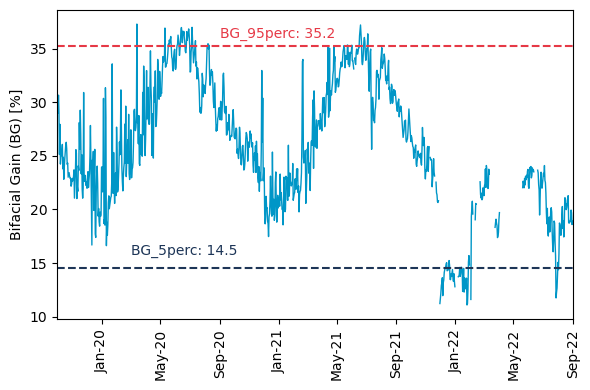

In [76]:
# plot bifacial gain

bifacial_gain = pd.DataFrame()
bifacial_gain['gain'] = (clean_mod['Tilted'] - clean_mod['monofacial'])/clean_mod['monofacial']

bifacial_gain.loc[clean_mod['monofacial']-clean_mod['Tilted']>0, 'gain'] = np.nan

bifacial_gain.loc[bifacial_gain['gain'] < 0, 'gain'] = np.nan
bifacial_gain.loc[bifacial_gain['gain'] > 0.39, 'gain'] = np.nan


bifacial_gain['date'] = clean_mod['date'].values
x_min = pd.to_datetime('2019-10-01')
#x_max = pd.to_datetime('2021-11-27')
x_max = pd.to_datetime('2022-09-01')

date_array = pd.DataFrame(pd.date_range(x_min,x_max,freq='d'), columns=['date'])

bifacial_gain['date'] = pd.to_datetime(bifacial_gain['date'])
bifacial_gain = bifacial_gain.merge(date_array, on='date', how='outer').sort_values(by='date').reset_index(drop=True)

bifacial_gain = bifacial_gain.loc[bifacial_gain['date'] >= x_min]
bifacial_gain = bifacial_gain.loc[bifacial_gain['date'] <= x_max]

bifacial_gain['gain'] = bifacial_gain['gain']*100

xformatter = mdates.DateFormatter('%b-%y')

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(bifacial_gain['date'], bifacial_gain['gain'], color='#0096c7', linewidth=1)
ax.set_ylabel('Bifacial Gain (BG) [%]')

ax.plot([x_min,x_max], [np.quantile(bifacial_gain['gain'].dropna(),0.95), np.quantile(bifacial_gain['gain'].dropna(),0.95)], '--', color='#e63946')
ax.plot([x_min,x_max], [np.quantile(bifacial_gain['gain'].dropna(),0.05), np.quantile(bifacial_gain['gain'].dropna(),0.05)], '--', color='#1d3557')

ax.text(pd.to_datetime('2020-09-1'), 36, 'BG_95perc: '+ str(round(np.quantile(bifacial_gain['gain'].dropna(),0.95),1)), 
        fontsize=10, color='#e63946')

ax.text(pd.to_datetime('2020-03-01'), 15.8, 'BG_5perc: '+ str(round(np.quantile(bifacial_gain['gain'].dropna(),0.05),1)), 
        fontsize=10, color='#1d3557')


ax.xaxis.set_major_formatter(xformatter)

ax.set_xlim([x_min, x_max])

plt.xticks(rotation='vertical')

fig.tight_layout()

fig.savefig('./Figures/11.bifacial_gain_full.tif')
fig.savefig('./Figures/11.bifacial_gain_full.svg')


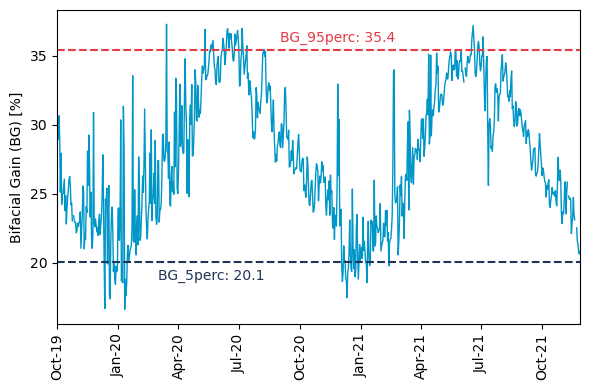

In [89]:
# plot bifacial gain - zoomed

bifacial_gain = pd.DataFrame()
bifacial_gain['gain'] = (clean_mod['Tilted'] - clean_mod['monofacial'])/clean_mod['monofacial']

bifacial_gain.loc[clean_mod['monofacial']-clean_mod['Tilted']>0, 'gain'] = np.nan

bifacial_gain.loc[bifacial_gain['gain'] < 0, 'gain'] = np.nan
bifacial_gain.loc[bifacial_gain['gain'] > 0.39, 'gain'] = np.nan


bifacial_gain['date'] = clean_mod['date'].values
x_min = pd.to_datetime('2019-10-01')
x_max = pd.to_datetime('2021-11-27')
#x_max = pd.to_datetime('2022-09-01')

date_array = pd.DataFrame(pd.date_range(x_min,x_max,freq='d'), columns=['date'])

bifacial_gain['date'] = pd.to_datetime(bifacial_gain['date'])
bifacial_gain = bifacial_gain.merge(date_array, on='date', how='outer').sort_values(by='date').reset_index(drop=True)

bifacial_gain = bifacial_gain.loc[bifacial_gain['date'] >= x_min]
bifacial_gain = bifacial_gain.loc[bifacial_gain['date'] <= x_max]

bifacial_gain['gain'] = bifacial_gain['gain']*100

xformatter = mdates.DateFormatter('%b-%y')

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(bifacial_gain['date'], bifacial_gain['gain'], color='#0096c7', linewidth=1)
ax.set_ylabel('Bifacial Gain (BG) [%]')

ax.plot([x_min,x_max], [np.quantile(bifacial_gain['gain'].dropna(),0.95), np.quantile(bifacial_gain['gain'].dropna(),0.95)], '--', color='#e63946')
ax.plot([x_min,x_max], [np.quantile(bifacial_gain['gain'].dropna(),0.05), np.quantile(bifacial_gain['gain'].dropna(),0.05)], '--', color='#1d3557')

ax.text(pd.to_datetime('2020-09-1'), 36, 'BG_95perc: '+ str(round(np.quantile(bifacial_gain['gain'].dropna(),0.95),1)), 
        fontsize=10, color='#e63946')

ax.text(pd.to_datetime('2020-03-01'), 18.8, 'BG_5perc: '+ str(round(np.quantile(bifacial_gain['gain'].dropna(),0.05),1)), 
        fontsize=10, color='#1d3557')


ax.xaxis.set_major_formatter(xformatter)

ax.set_xlim([x_min, x_max])

plt.xticks(rotation='vertical')

fig.tight_layout()

fig.savefig('./Figures/11.bifacial_gain_zoom.tif')
fig.savefig('./Figures/11.bifacial_gain_zoom.svg')

In [78]:
### comparison between soiled bifacial tilted and bifacial vertical clean

mix_mod = monofac_EY_day[['date','MPP_mono_clean_all']].rename(columns={"MPP_mono_clean_all": "monofacial"})
mix_mod = mix_mod.merge(bifac_tilt_EY_day[['date','MPP_bf_tilt_soil_all']], on='date', how='inner').rename(columns={"MPP_bf_tilt_soil_all": "Tilted"})
mix_mod = mix_mod.merge(bifac_vert_EY_day[['date','MPP_bf_EW_clean_all']], on='date', how='inner').rename(columns={"MPP_bf_EW_clean_all": "Vertical"})

mix_mod['ts_YM'] = pd.to_datetime(mix_mod['date']).dt.strftime("%b-%y")

In [79]:
box_plot_data_mix = mix_mod[['ts_YM','Tilted','Vertical']].melt(id_vars=['ts_YM'], var_name='tech', value_name='Normalized Power (W/Wp)')


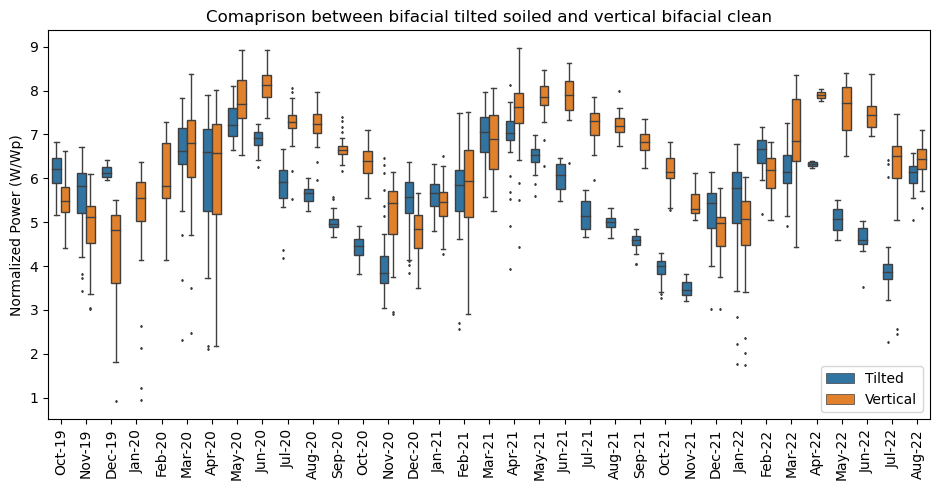

In [80]:
# plot Comaprison between bifacial tilted soiled and vertical bifacila clean

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(9.5,5))
sns.boxplot(data=box_plot_data_mix, y='Normalized Power (W/Wp)', ax=ax, x='ts_YM', hue='tech',dodge=True,
            width=0.7,fliersize=1,linewidth=1)

plt.xticks(rotation='vertical')
plt.xlabel('')

plt.title('Comaprison between bifacial tilted soiled and vertical bifacial clean')
fig.tight_layout()

plt.legend(loc=4)

fig.savefig('./Figures/12.comparing_bifac_tiltSoil_vertclean.tif')
fig.savefig('./Figures/12.comparing_bifac_tiltSoil_vertclean.svg')

In [81]:
# calculate the % difference between the tilted and the vertical

# calculate the % difference between the tilted and the vertical
mix_mod['diff'] = (mix_mod['Vertical'] - mix_mod['Tilted'])/mix_mod['Tilted']*100

# group by the result at monthly level
mix_mod_month = mix_mod[['ts_YM', 'date', 'Tilted','Vertical']].dropna().groupby(by='ts_YM', as_index=False).agg(
{'date':'first', 'Tilted':'sum','Vertical':'sum'}).sort_values(by='date').reset_index(drop=True)

# calculate the monthly difference
mix_mod_month['diff'] = (mix_mod_month['Vertical'] - mix_mod_month['Tilted'])/mix_mod_month['Tilted']*100


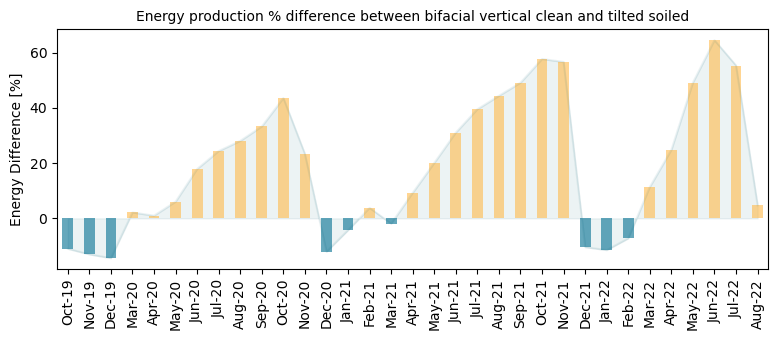

In [82]:
# plot monthly % difference between tilted soiled and vertical bifacial clean

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(8,3.5))

mix_mod_month['positive'] = mix_mod_month['diff'] > 0

mix_mod_month.plot.area(x = 'ts_YM', y='diff',stacked=False, ax=ax, color='#005f73', label='difference', alpha=0.075)

mix_mod_month.plot.bar(x = 'ts_YM', y='diff',stacked=False, ax=ax,
                         label='difference', width=0.5,alpha=0.6, 
                         color=mix_mod_month['positive'].map({True: '#ffba49', False: '#006e90'}))
ax.set_ylabel('Energy Difference [%]')
ax.set_xlabel('')
ax.set_title('Energy production % difference between bifacial vertical clean and tilted soiled', fontsize=10)

ax.legend().set_visible(False)
fig.tight_layout()

fig.savefig('./Figures/13.energy_diff_vertClen-tiltSoil.tif')
fig.savefig('./Figures/13.energy_diff_vertClen-tiltSoil.svg')

In [83]:
### comparison between soiled bifacial tilted and bifacial vertical soiled

soil_mod = monofac_EY_day[['date','MPP_mono_clean_all']].rename(columns={"MPP_mono_clean_all": "monofacial"})
soil_mod = soil_mod.merge(bifac_tilt_EY_day[['date','MPP_bf_tilt_soil_all']], on='date', how='inner').rename(columns={"MPP_bf_tilt_soil_all": "Tilted"})
soil_mod = soil_mod.merge(bifac_vert_EY_day[['date','MPP_bf_EW_soil_all']], on='date', how='inner').rename(columns={"MPP_bf_EW_soil_all": "Vertical"})

soil_mod['ts_YM'] = pd.to_datetime(soil_mod['date']).dt.strftime("%b-%y")

In [84]:
box_plot_data_soil = soil_mod[['ts_YM','Tilted','Vertical']].dropna().melt(id_vars=['ts_YM'], var_name='tech', value_name='Normalized Power (W/Wp)')


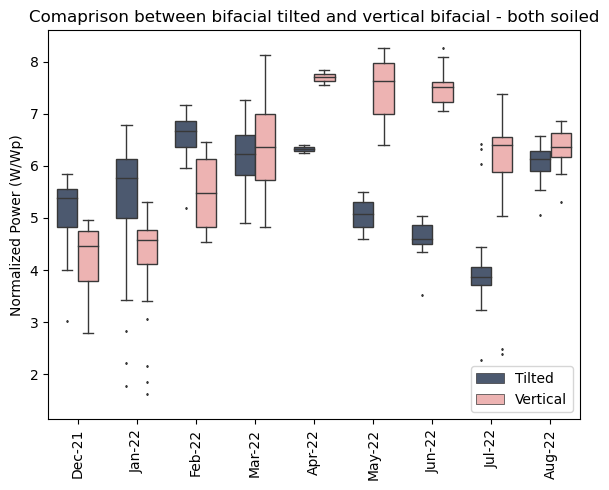

In [85]:
# plot Comaprison between bifacial tilted soiled and vertical bifacila soiled

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

my_pal = {"Tilted": "#465775", "Vertical":"#f7a9a8"}

fig, ax = plt.subplots(figsize=(6,5))
sns.boxplot(data=box_plot_data_soil, y='Normalized Power (W/Wp)', ax=ax, x='ts_YM', hue='tech',dodge=True,
            width=0.7,fliersize=1,linewidth=1, palette=my_pal)

plt.xticks(rotation='vertical')
plt.xlabel('')

plt.title('Comaprison between bifacial tilted and vertical bifacial - both soiled')
fig.tight_layout()

plt.legend(loc=4)

fig.savefig('./Figures/14.comparing_bifac_tilt_vert_soiled.tif')
fig.savefig('./Figures/14.comparing_bifac_tilt_vert_soiled.svg')

In [86]:
# calculate the % difference between the tilted and the vertical
soil_mod['diff'] = (soil_mod['Vertical'] - soil_mod['Tilted'])/soil_mod['Tilted']*100

# group by the result at monthly level
soil_mod_month = soil_mod[['ts_YM', 'date', 'Tilted','Vertical']].dropna().groupby(by='ts_YM', as_index=False).agg(
{'date':'first', 'Tilted':'sum','Vertical':'sum'}).sort_values(by='date').reset_index(drop=True)

# calculate the monthly difference
soil_mod_month['diff'] = (soil_mod_month['Vertical'] - soil_mod_month['Tilted'])/soil_mod_month['Tilted']*100

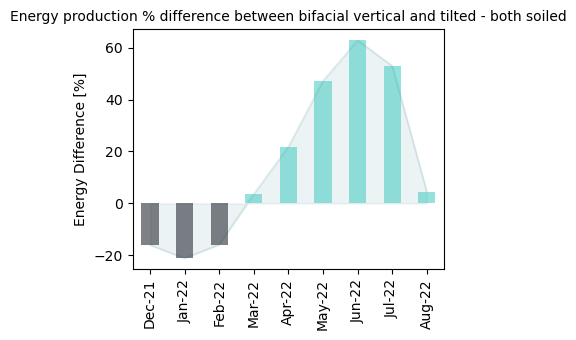

In [87]:
# plot monthly % difference between tilted and vertical bifacial both soiled

%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(4,3.5))

soil_mod_month['positive'] = soil_mod_month['diff'] > 0

soil_mod_month.plot.area(x = 'ts_YM', y='diff',stacked=False, ax=ax, color='#005f73', label='difference', alpha=0.075)

soil_mod_month.plot.bar(x = 'ts_YM', y='diff',stacked=False, ax=ax,
                         label='difference', width=0.5,alpha=0.6, 
                         color=soil_mod_month['positive'].map({True: '#4ecdc4', False: '#292f36'}))
ax.set_ylabel('Energy Difference [%]')
ax.set_xlabel('')
ax.set_title('Energy production % difference between bifacial vertical and tilted - both soiled', fontsize=10)

ax.legend().set_visible(False)
fig.tight_layout()

fig.savefig('./Figures/15.energy_diff_vert-tilt_Soiled.tif')
fig.savefig('./Figures/15.energy_diff_vert-tilt_Soiled.svg')